In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import io

from tqdm.notebook import tqdm
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, Rescaling
from keras.layers import RandomContrast, RandomZoom, RandomFlip, RandomRotation, RandomTranslation, RandomCrop, RandomBrightness
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LambdaCallback
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from google.colab import files

AUTOTUNE = tf.data.AUTOTUNE
np.set_printoptions(suppress=True)

#### Loading Dataset


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="QzWRLvI8sgZh0N2qBYaC")
project = rf.workspace("ignatius-pandu-adityawan-m038dsx0594-rzdje").project("paddysicknessclassification")
dataset = project.version(3).download("multiclass")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=1b24de4e8a697eb739eac9f9aa620fc1822de970358d9f509215a003ca912833
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to PaddySicknessClassification-3 in multiclass:: 100%|██████████| 8297/8297 [00:04<00:00, 1844.99it/s]


In [8]:
df = pd.read_csv("/content/PaddySicknessClassification-3/train/_classes.csv")
dict_disease = {}

for number, name in enumerate(df.columns):
    if name == 'filename':continue              # skip 1st column
    dict_disease[number-1] = name.strip()
dict_disease = {key: dict_disease[key] for key in dict_disease if key != 'Unlabeled'}
img_size = 224
print (dict_disease)

{0: 'BacterialBlight', 1: 'Blast', 2: 'Brownspot', 3: 'Healthy', 4: 'Leaf_Scald', 5: 'Tungro'}


In [7]:
def loadImg(filenames, labels, size, resize, rescale):
    images = []
    for i, name in enumerate(nameMsg := tqdm(filenames)):
        nameMsg.set_postfix_str(name)
        try:
            img = tf.keras.preprocessing.image.load_img(name)
        except:
            labels = np.delete(labels, i)
            continue
        img = tf.cast(img, tf.float32)

        if resize:
            img = tf.image.resize(img, (size, size))

        if rescale == 1:
            img = img / 255
        elif rescale == 2:
            img = (img / 127.5) - 1
        elif rescale == 0:
            img = tf.cast(img, tf.uint8)

        images.append(img)
    return images, labels


def parseData(filename, delimiter=',', size=False, resize=False, rescale=1, return_format='dataset'):
    if resize:
        if not size:
            raise Exception('Size must be specified when resize is true.')

    if return_format.lower() not in ['dataset', 'split']:
        raise Exception("Return format unspecified.")
    
    loaded_dataset = pd.read_csv(str(filename)+"_classes.csv", delimiter=delimiter)
    img_dir = np.array(loaded_dataset.pop('filename'))
    img_dir = np.ndarray.flatten(img_dir)

    for row, img_path in enumerate(img_dir):
        img_dir[row] = os.path.join(filename, img_path)

    labels = np.array(loaded_dataset.idxmax(axis=1).str.strip().astype(
        'category').cat.codes).reshape(-1, 1)

    images, labels = loadImg(img_dir, labels, size, resize, rescale)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if return_format == 'dataset':
        return dataset
    elif return_format == 'split':
        return images, labels
    else:
        raise Exception("Return format unspecified.")


def confusionMatrix(epoch, logs):
    yhat = model.predict(test_images)
    yhat = np.argmax(yhat, axis=1)
    cm = confusion_matrix(test_labels, yhat)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm)
    for (x, y), value in np.ndenumerate(cm):
        plt.text(x, y, f"{value:.2f}", va="center", ha="center", color='white')
    ax.set_title(f"Confusion Matrix on epoch {epoch}\nVal accuracy: {logs.get('val_accuracy'):.2f}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticks_position('bottom')
    fig.savefig(f"/content/CM Epoch {epoch}.jpg")

In [9]:
with tf.device('/gpu:0'):
    train_dataset = parseData("/content/PaddySicknessClassification-3/train/", size=img_size,
                              resize=True, rescale=False) # Rescale = 1 untuk normalisasi [0,1], 2 untuk normalisasi [-1,1], 0 kalau gambar untuk print, selain itu gambar tdk diproses
    valid_dataset = parseData("/content/PaddySicknessClassification-3/valid/", size=img_size,
                              resize=True, rescale=False) # Rescale = 1 untuk normalisasi [0,1], 2 untuk normalisasi [-1,1], 0 kalau gambar untuk print, selain itu gambar tdk diproses

  0%|          | 0/6308 [00:00<?, ?it/s]

  0%|          | 0/1194 [00:00<?, ?it/s]

In [10]:
with tf.device('/gpu:0'):
    test_images_data, test_labels = parseData("/content/PaddySicknessClassification-3/test/", size=img_size,
                                 resize=True, rescale=False, return_format='split') # Rescale = 1 untuk normalisasi [0,1], 2 untuk normalisasi [-1,1], 0 kalau gambar untuk print, selain itu gambar tdk diproses
    
    test_images = tf.data.Dataset.from_tensor_slices(test_images_data)
    test_images = test_images.cache().batch(32).prefetch(AUTOTUNE)

  0%|          | 0/787 [00:00<?, ?it/s]

In [11]:
train = train_dataset.cache('train_dataset').shuffle(128).batch(32).prefetch(AUTOTUNE)
valid = valid_dataset.cache().batch(32).prefetch(AUTOTUNE)

#### Buat Model


In [12]:
base_model = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5", trainable=False)

In [27]:
model = Sequential([
    Input((img_size, img_size, 3)),
    Rescaling(1/255),               # range [0,1]
    # Rescaling(1/127.5, offset=-1),  # range [-1,1]
    RandomFlip(),
    RandomRotation(factor=0.3),
    RandomZoom(height_factor=(-0.1, 0.1)),
    RandomBrightness(factor=(-0.1,0.1), value_range=[0,1]),
    base_model,
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.2),
    Dense(512, activation = 'relu'),
    Dense(32, 'relu'),
    Dense(len(dict_disease.keys()), activation='softmax')
])

model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(0.0001),
    metrics=['accuracy']
)

bestCB = ModelCheckpoint(filepath='./checkpoint/best/', monitor='val_accuracy',
                         mode='max', verbose=1, save_best_only=True)

cmCB = LambdaCallback(on_epoch_end=confusionMatrix)

model.build([None, img_size, img_size, 3])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_8 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_brightness_8 (Random  (None, 224, 224, 3)      0         
 Brightness)                                                     
                                                                 
 keras_layer (KerasLayer)    (None, 1024)             

Epoch 1/100
198/198 [==============================] - ETA: 0s - loss: 1.8506 - accuracy: 0.7083
Epoch 1: val_accuracy improved from -inf to 0.74539, saving model to ./checkpoint/best/
198/198 [==============================] - 35s 114ms/step - loss: 1.8506 - accuracy: 0.7083 - val_loss: 1.6968 - val_accuracy: 0.7454
Epoch 2/100
195/198 [============================>.] - ETA: 0s - loss: 1.3616 - accuracy: 0.8617
Epoch 2: val_accuracy improved from 0.74539 to 0.79648, saving model to ./checkpoint/best/
198/198 [==============================] - 13s 63ms/step - loss: 1.3603 - accuracy: 0.8619 - val_loss: 1.5921 - val_accuracy: 0.7965
Epoch 3/100
196/198 [============================>.] - ETA: 0s - loss: 1.2040 - accuracy: 0.9047
Epoch 3: val_accuracy improved from 0.79648 to 0.81323, saving model to ./checkpoint/best/
198/198 [==============================] - 13s 65ms/step - loss: 1.2034 - accuracy: 0.9049 - val_loss: 1.5151 - val_accuracy: 0.8132
Epoch 4/100
196/198 [==================

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


197/198 [============================>.] - ETA: 0s - loss: 0.4841 - accuracy: 0.9645
Epoch 22: val_accuracy did not improve from 0.87018
198/198 [==============================] - 6s 28ms/step - loss: 0.4841 - accuracy: 0.9645 - val_loss: 0.9801 - val_accuracy: 0.8660
Epoch 23/100
197/198 [============================>.] - ETA: 0s - loss: 0.4663 - accuracy: 0.9645
Epoch 23: val_accuracy did not improve from 0.87018
198/198 [==============================] - 6s 29ms/step - loss: 0.4662 - accuracy: 0.9645 - val_loss: 1.0444 - val_accuracy: 0.8660
Epoch 24/100
196/198 [============================>.] - ETA: 0s - loss: 0.4506 - accuracy: 0.9636
Epoch 24: val_accuracy did not improve from 0.87018
198/198 [==============================] - 5s 26ms/step - loss: 0.4504 - accuracy: 0.9637 - val_loss: 0.9981 - val_accuracy: 0.8618
Epoch 25/100
197/198 [============================>.] - ETA: 0s - loss: 0.4398 - accuracy: 0.9645
Epoch 25: val_accuracy improved from 0.87018 to 0.88023, saving model

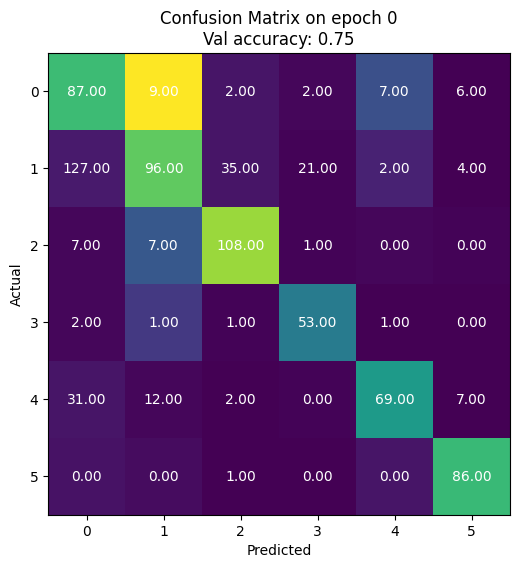

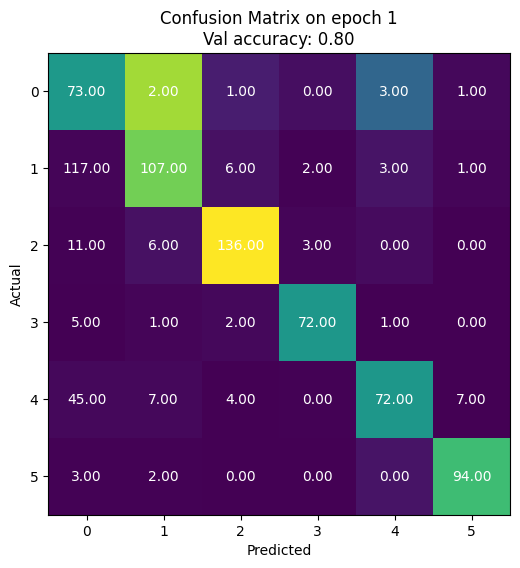

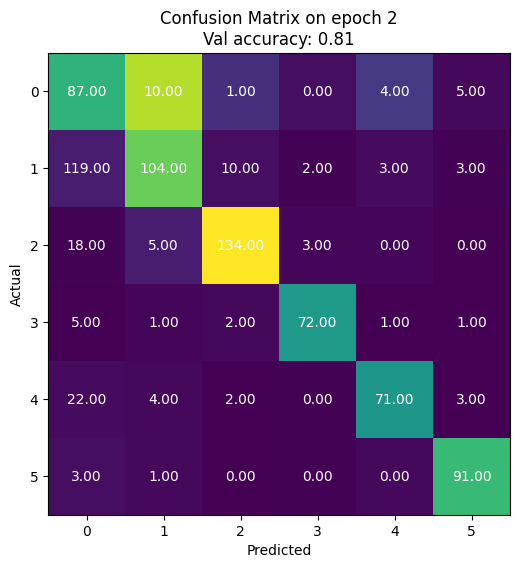

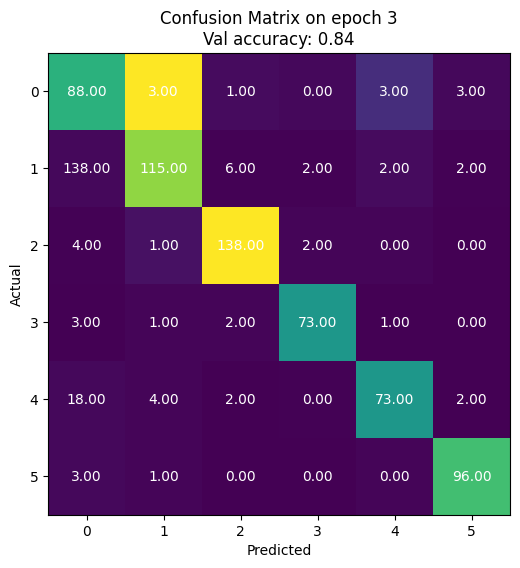

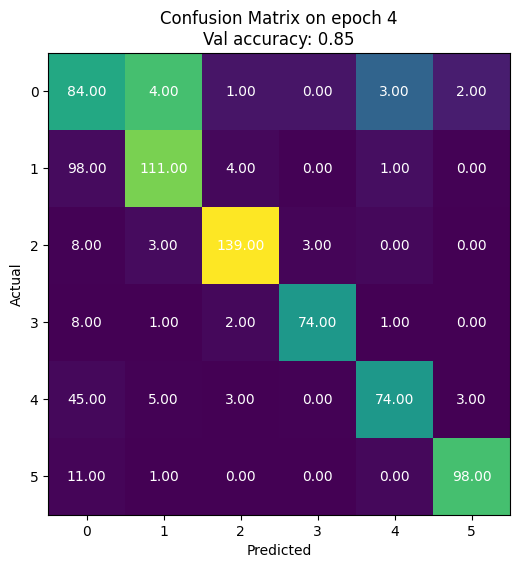

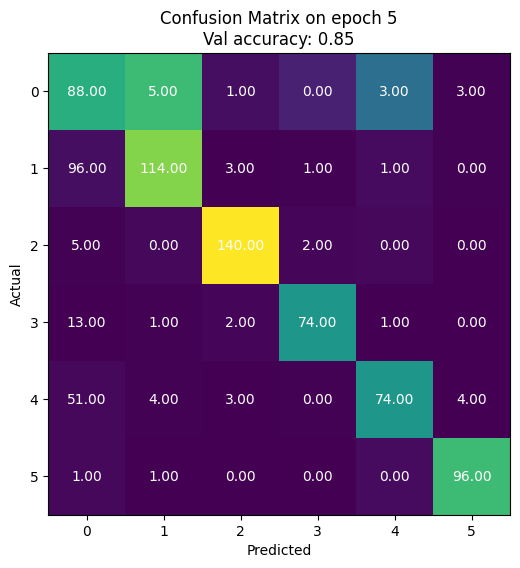

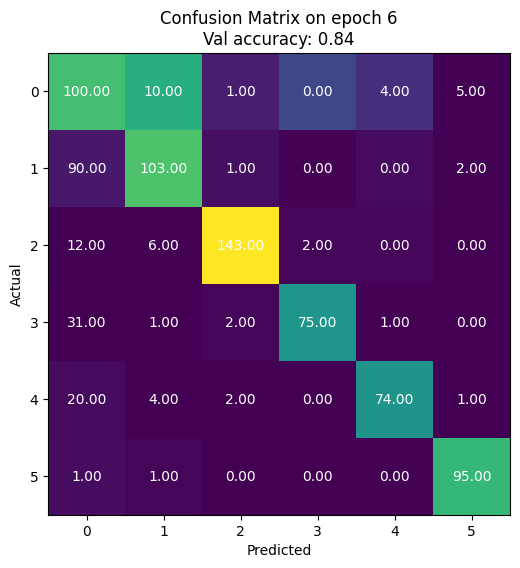

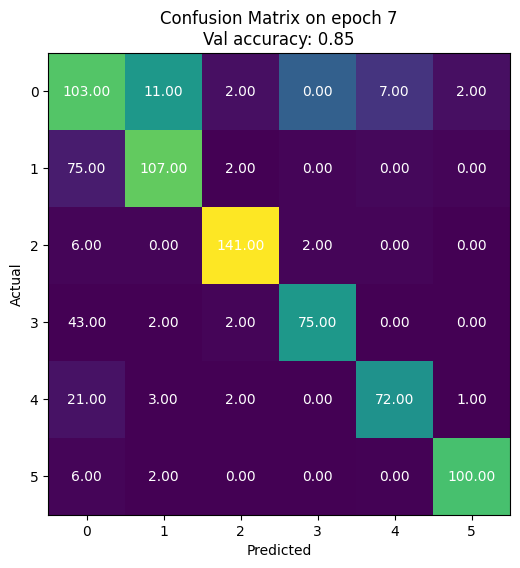

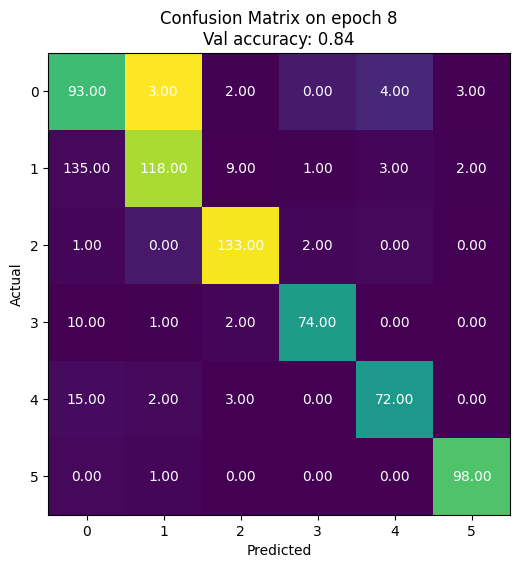

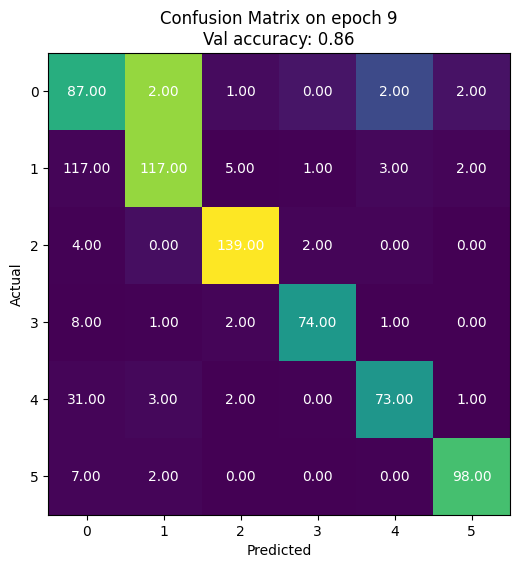

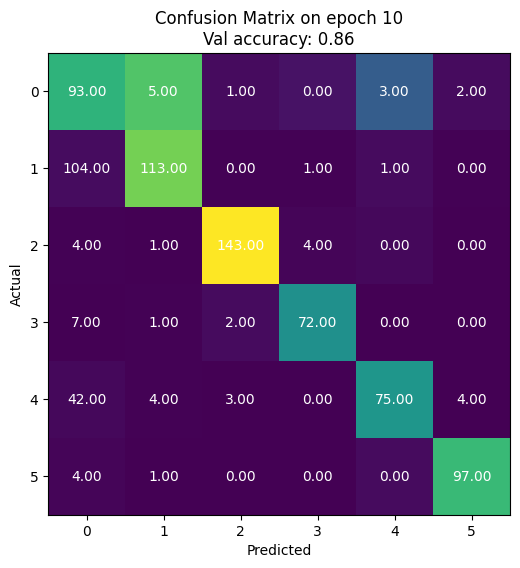

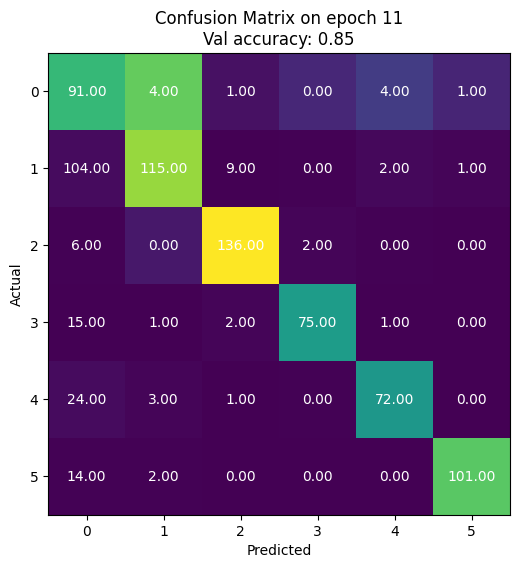

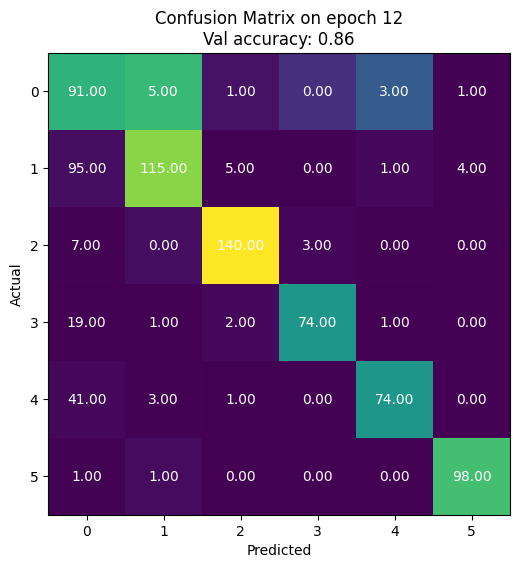

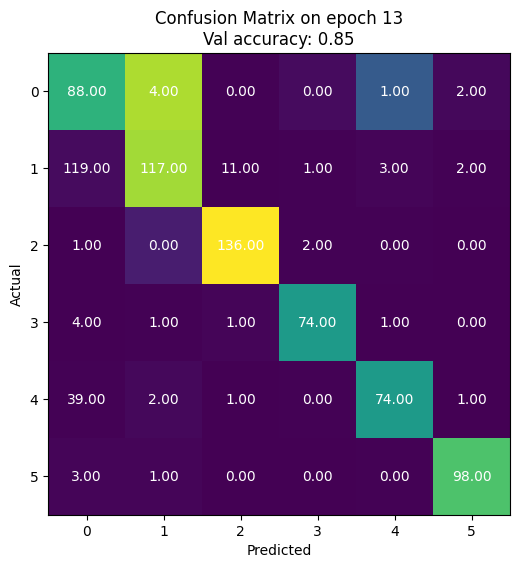

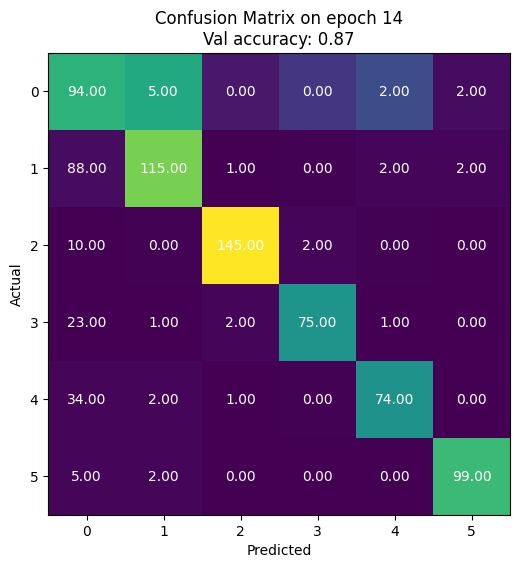

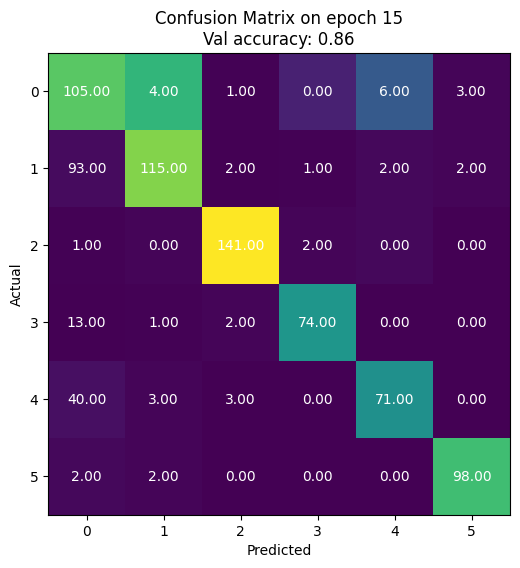

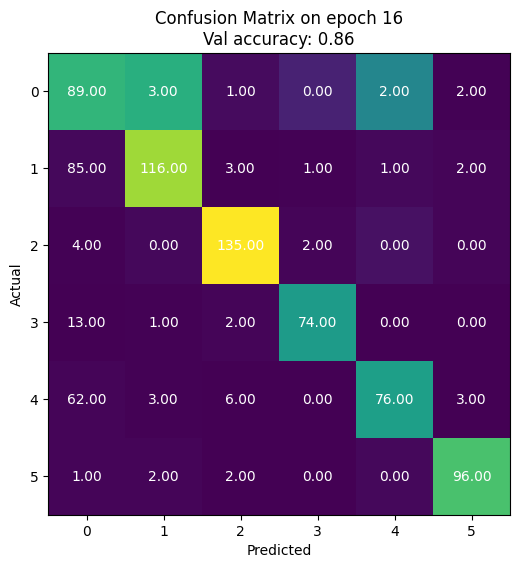

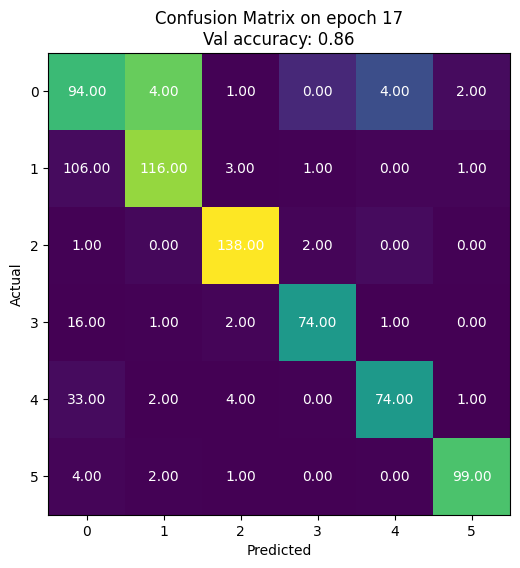

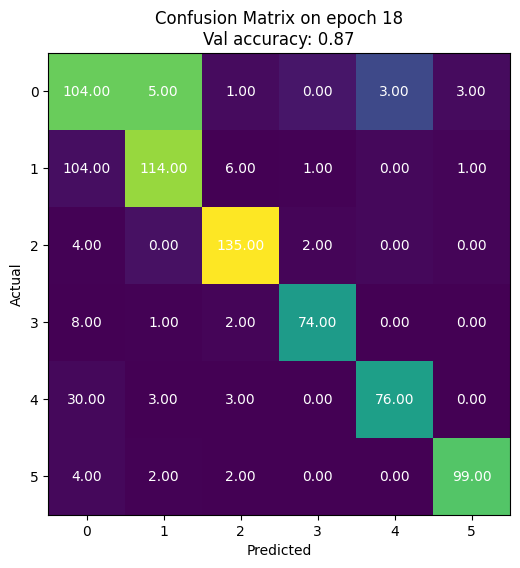

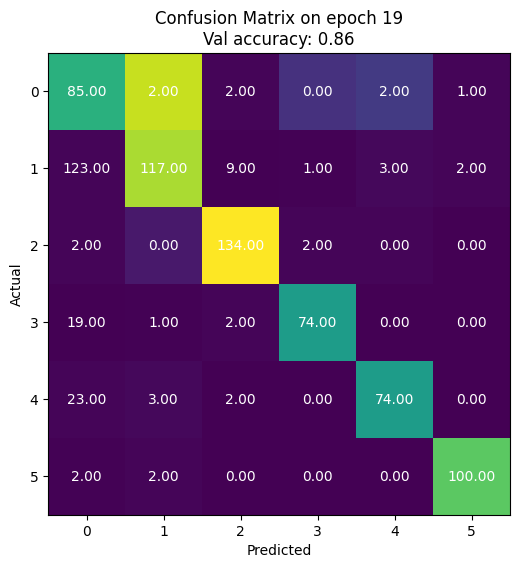

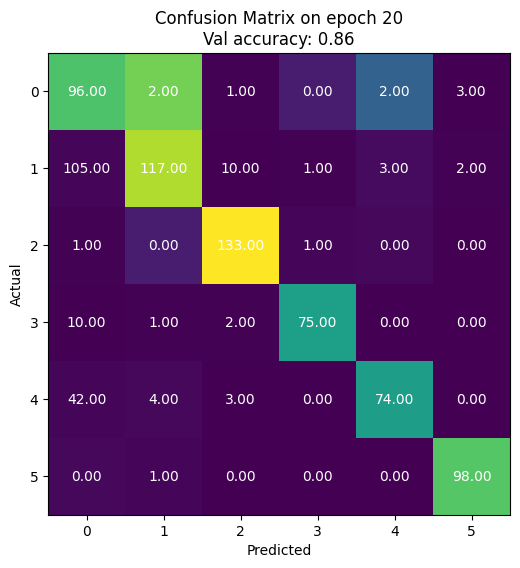

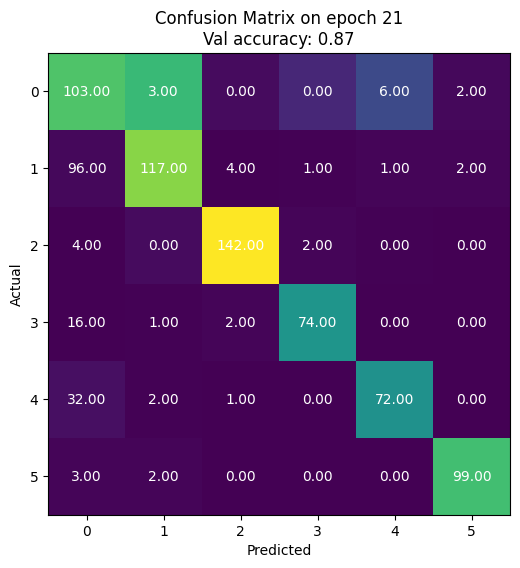

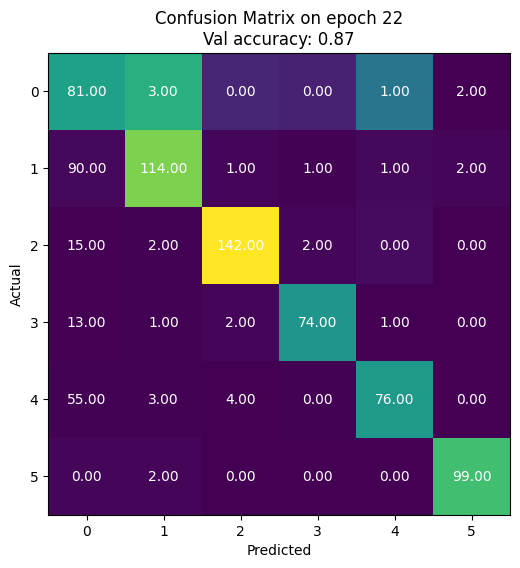

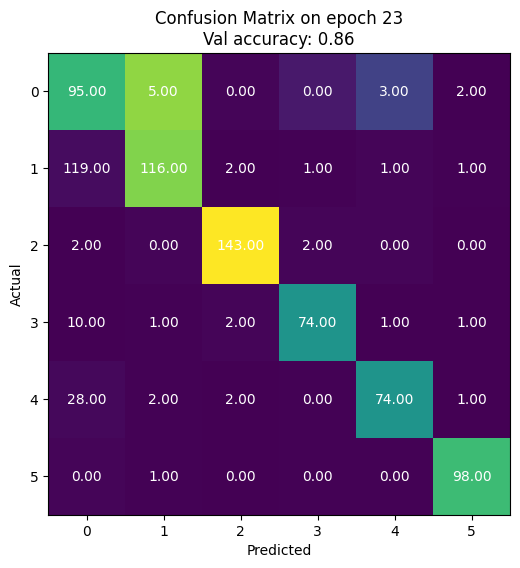

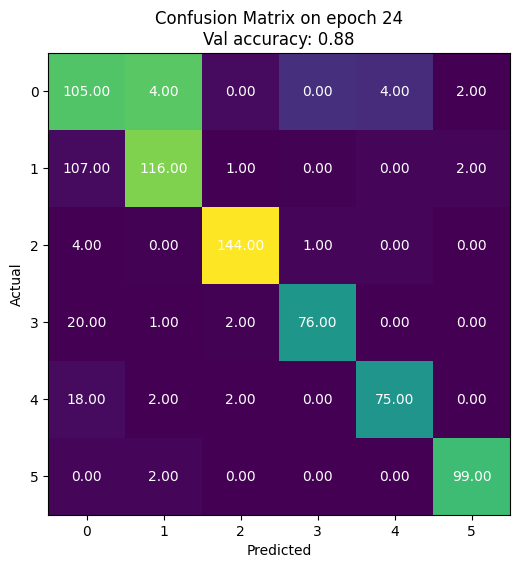

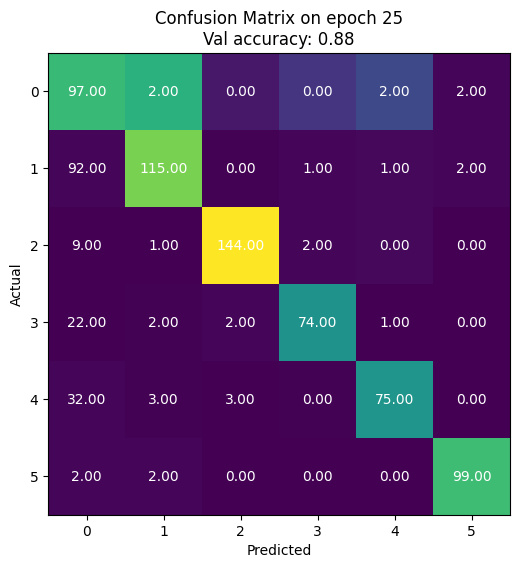

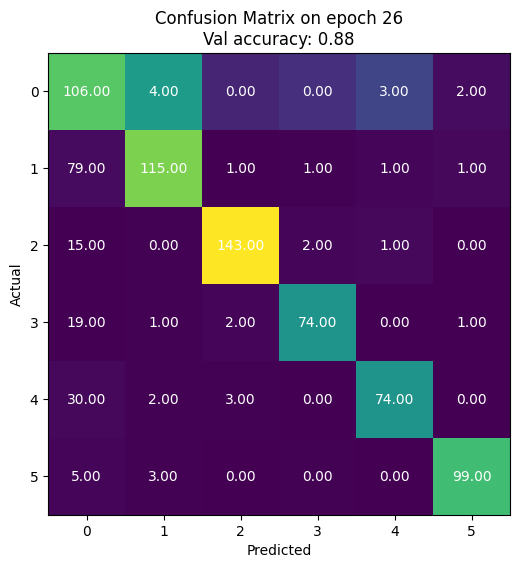

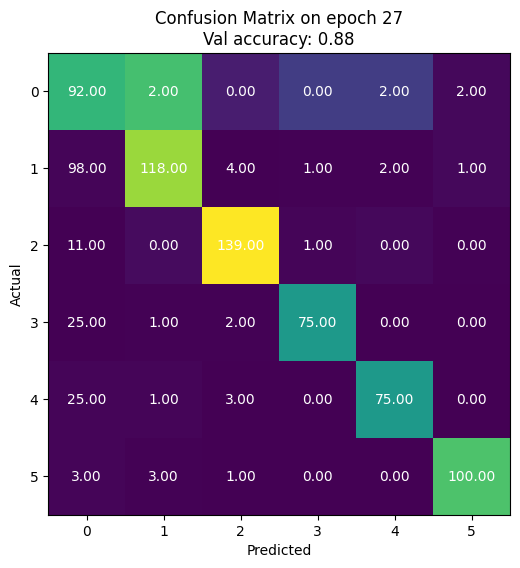

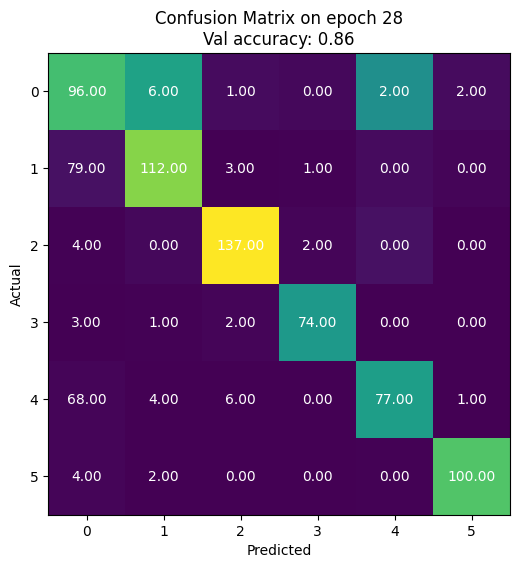

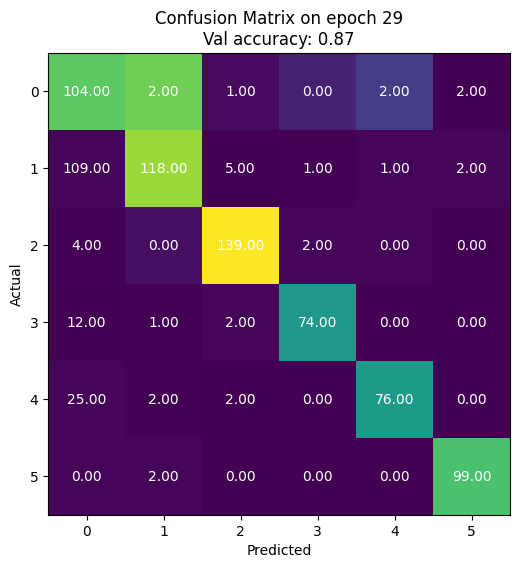

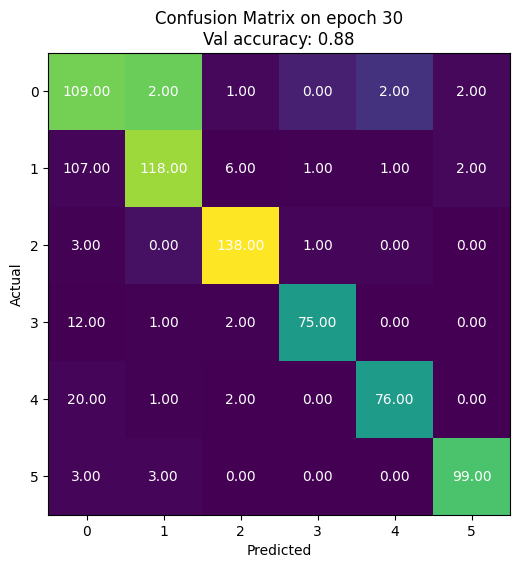

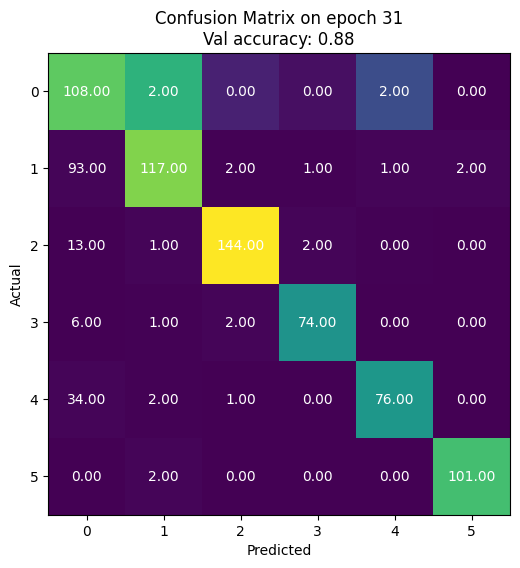

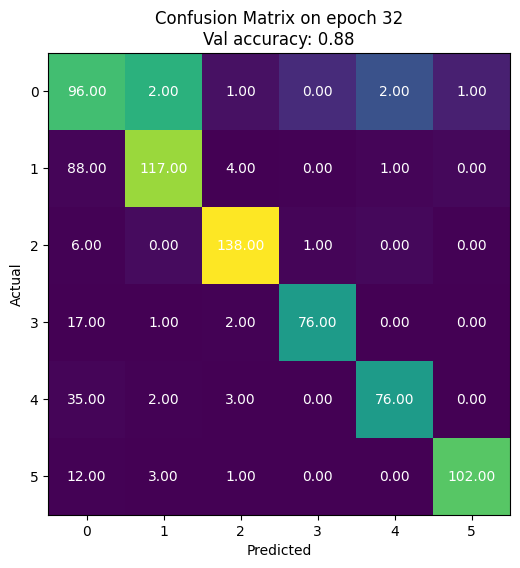

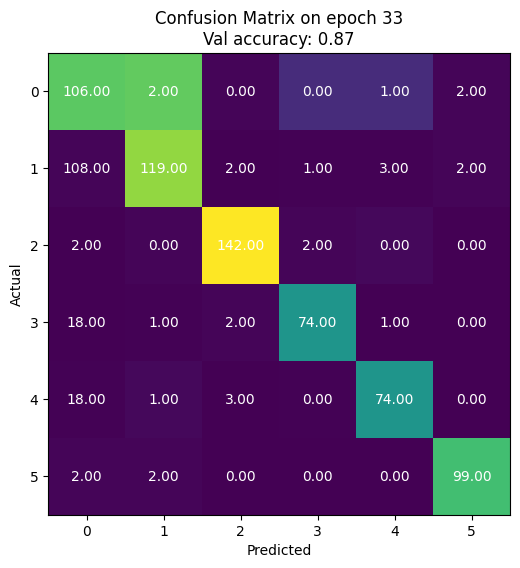

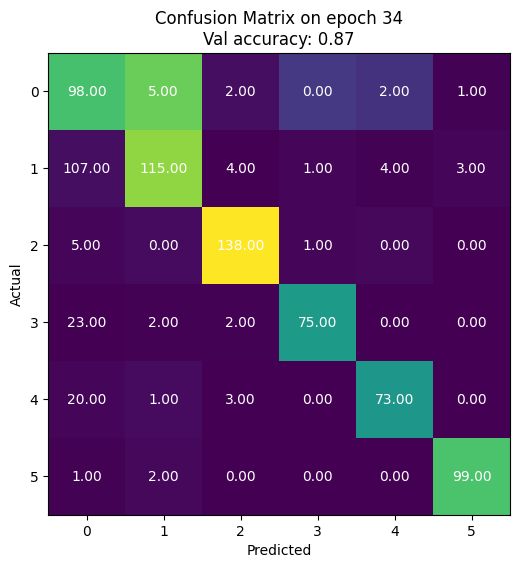

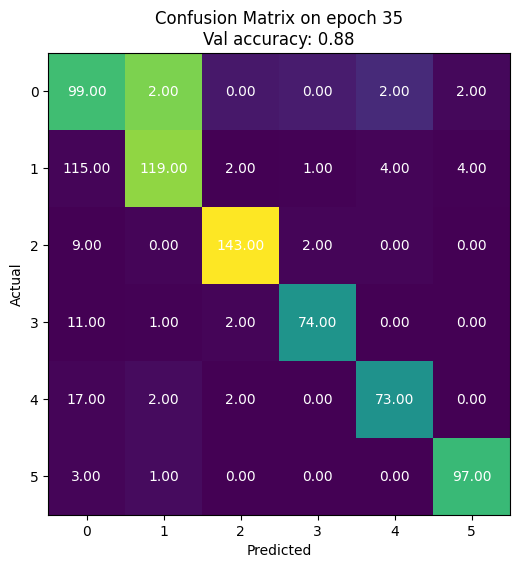

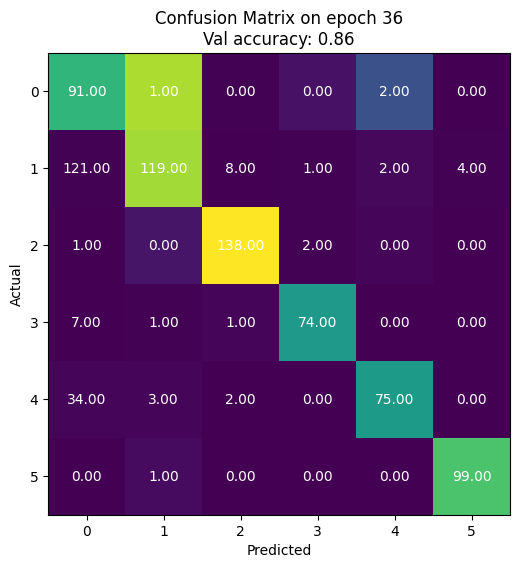

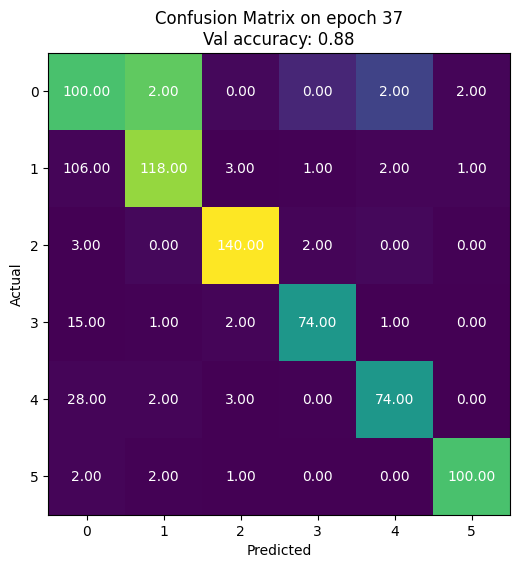

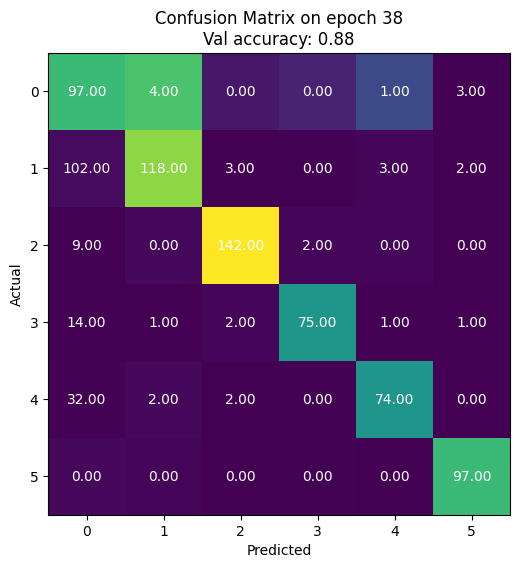

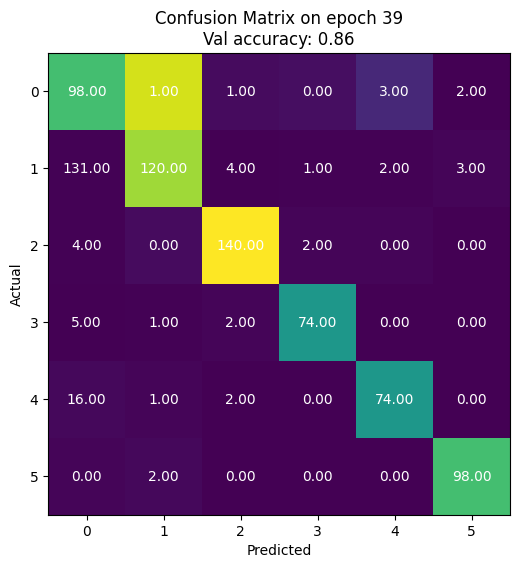

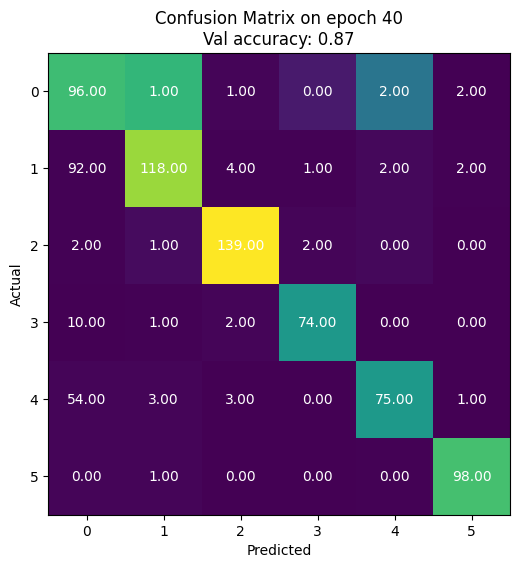

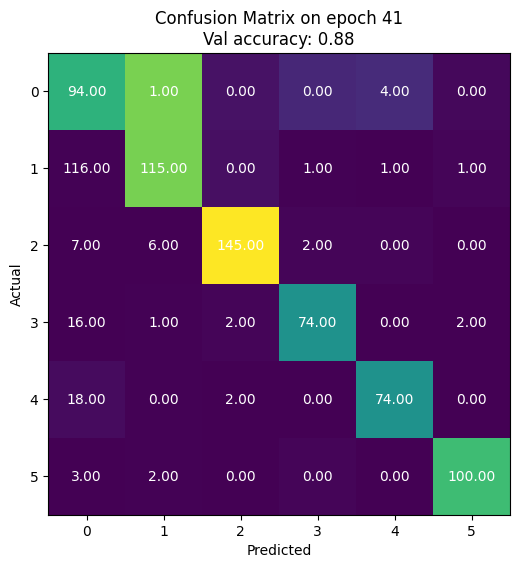

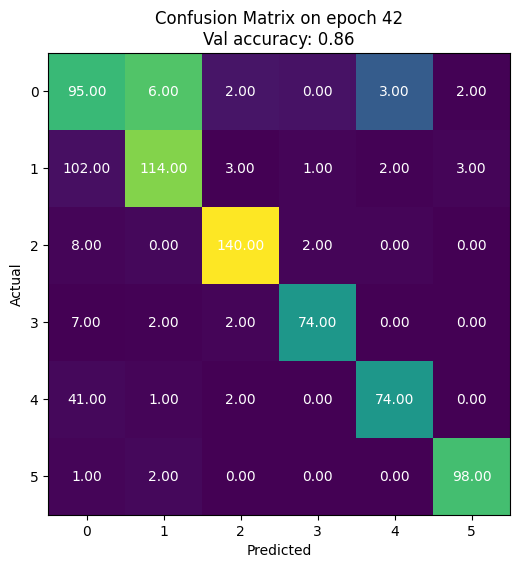

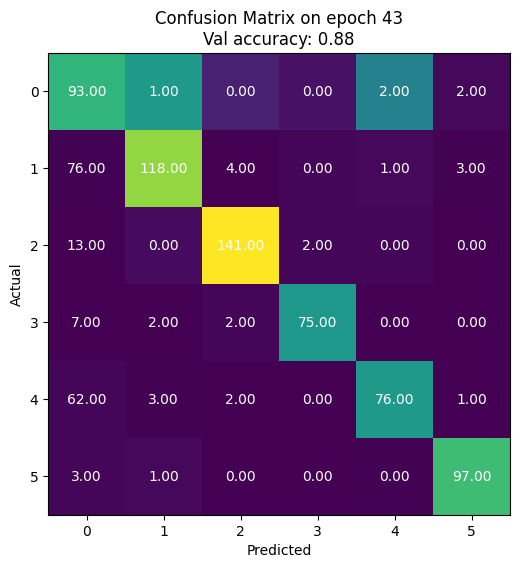

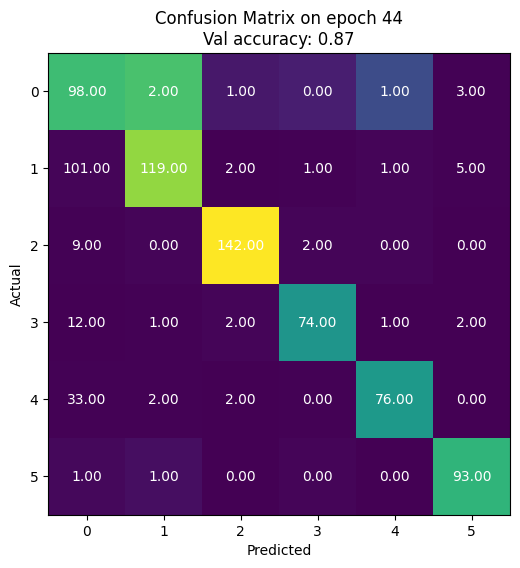

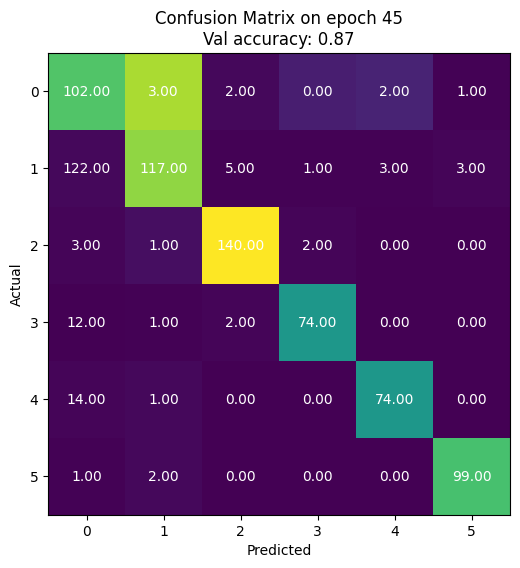

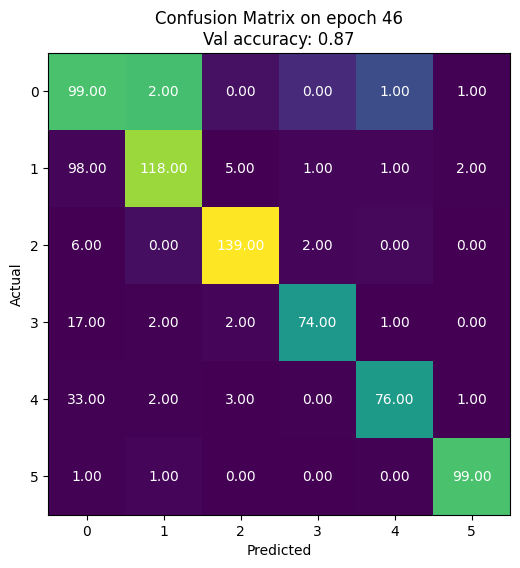

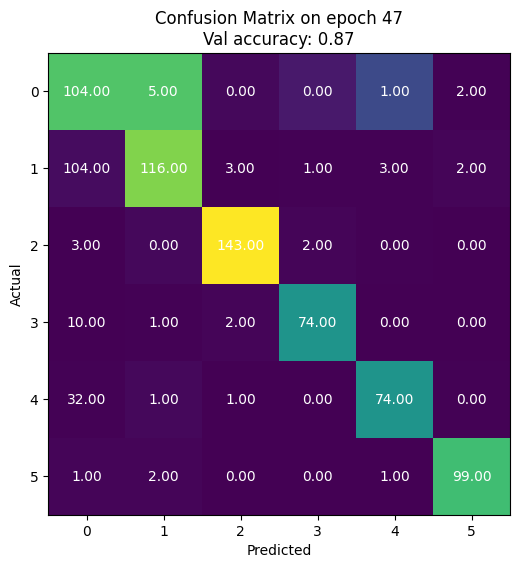

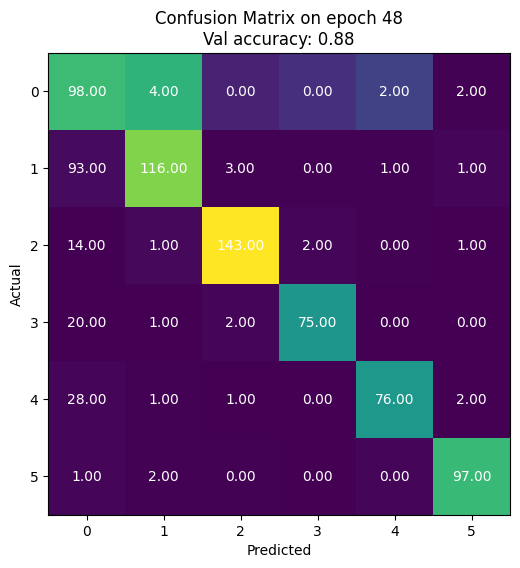

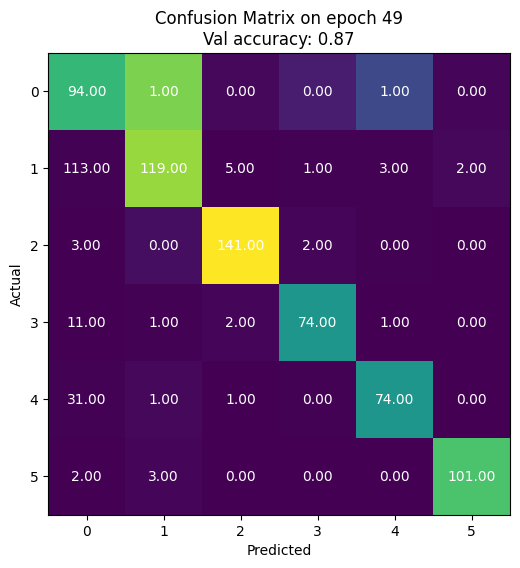

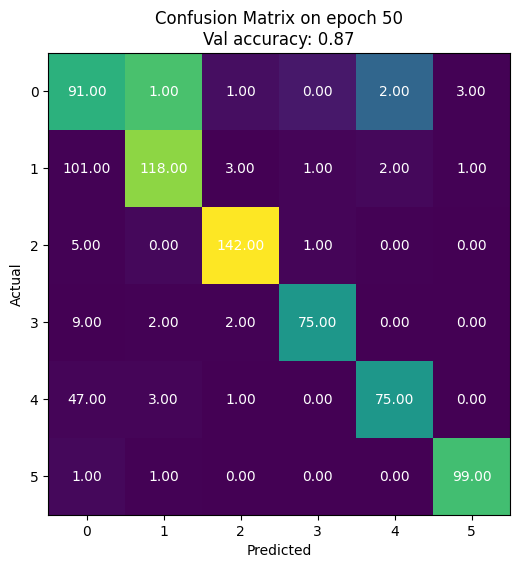

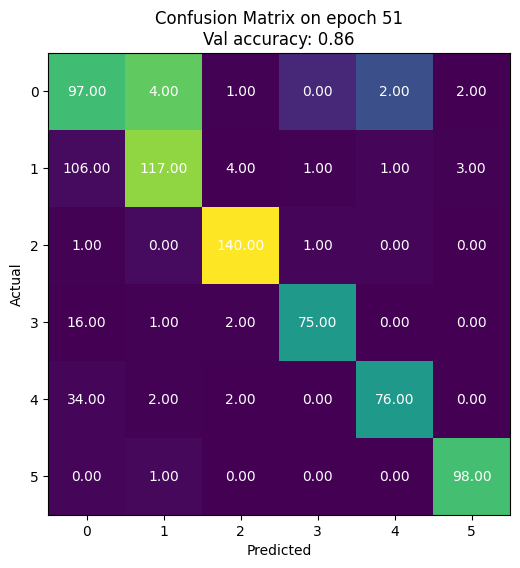

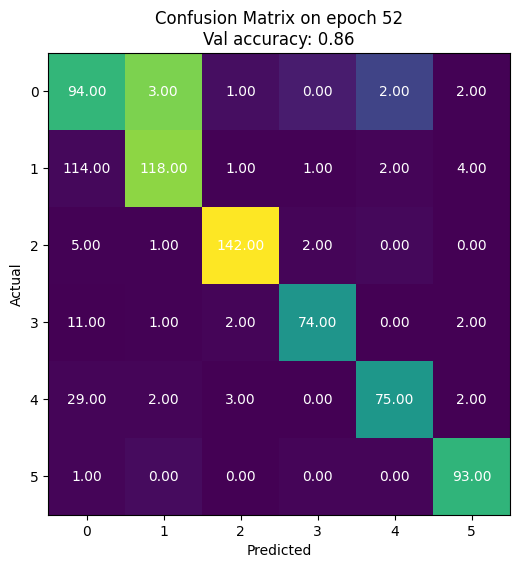

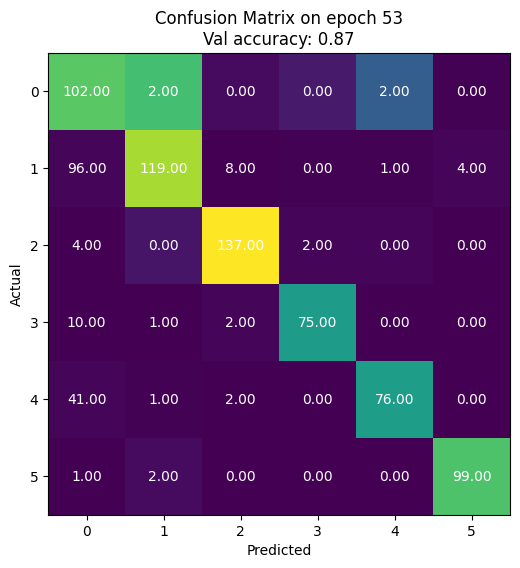

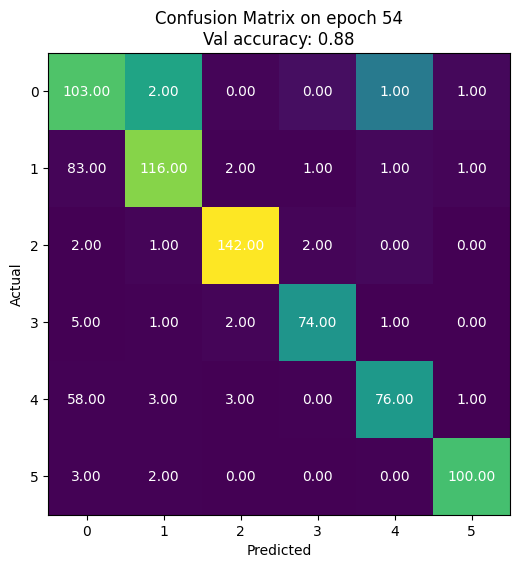

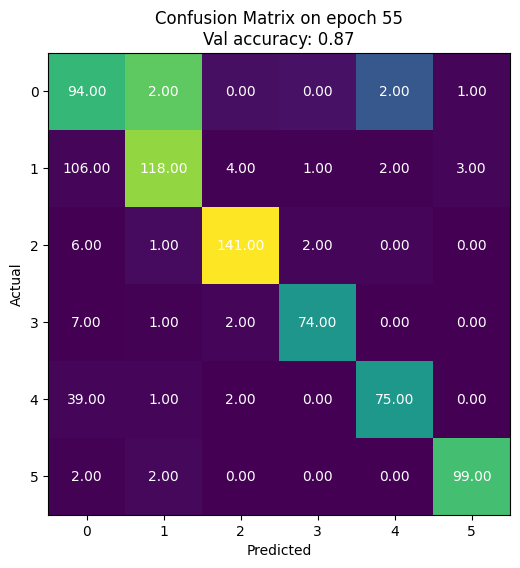

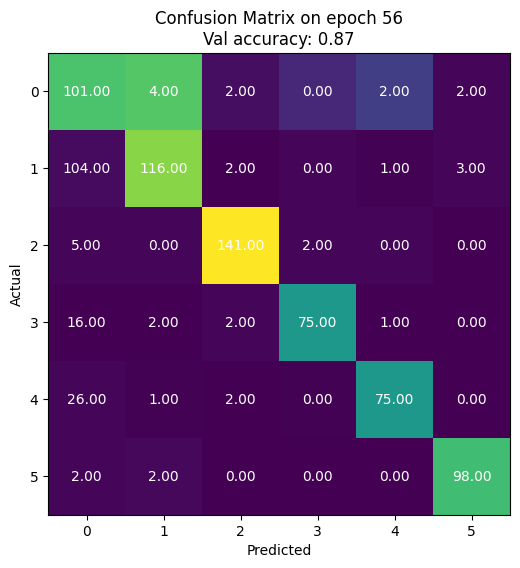

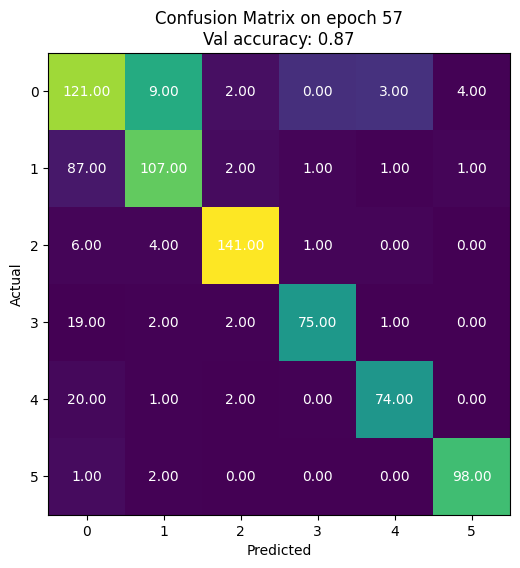

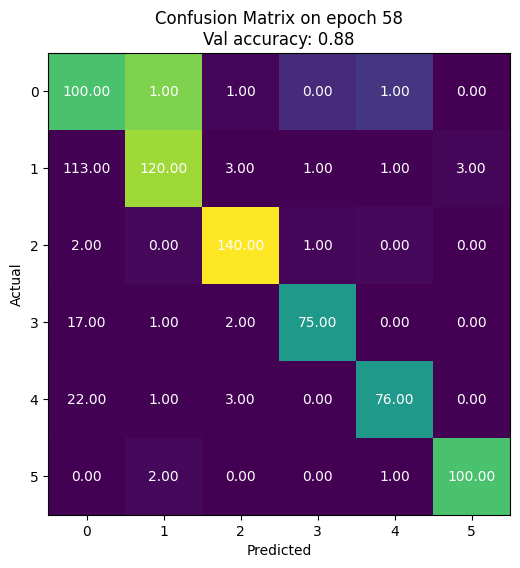

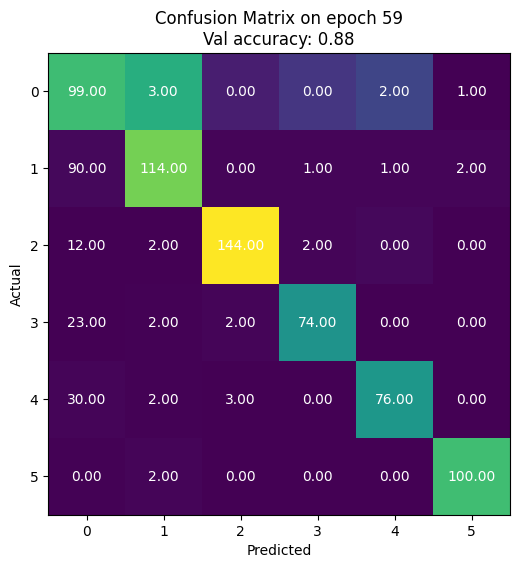

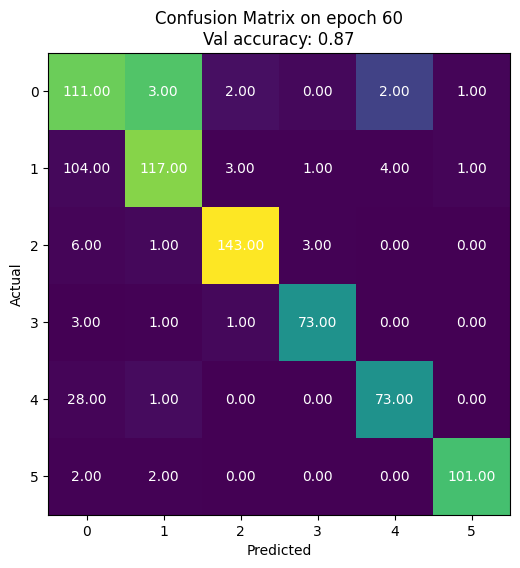

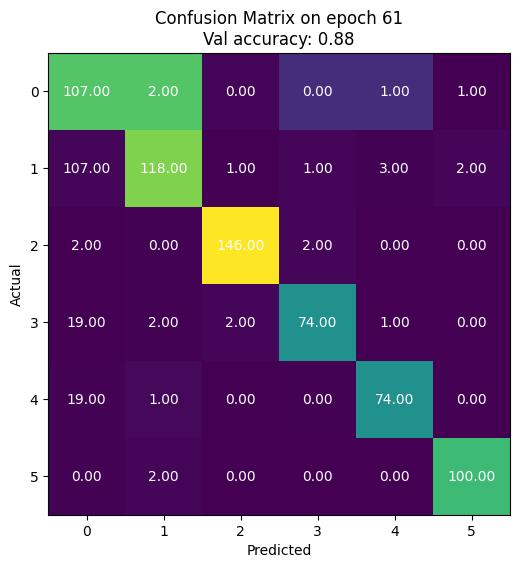

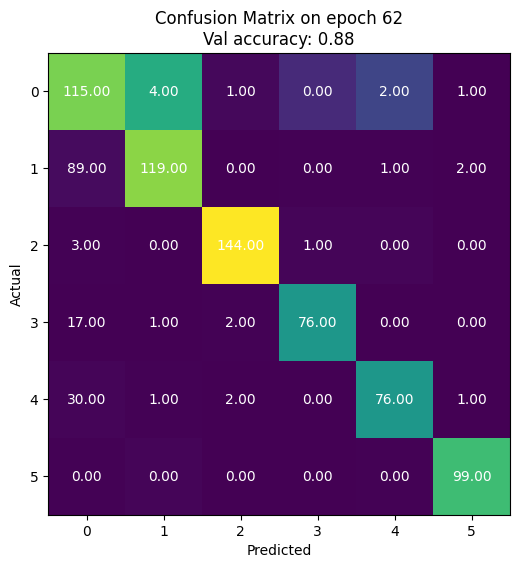

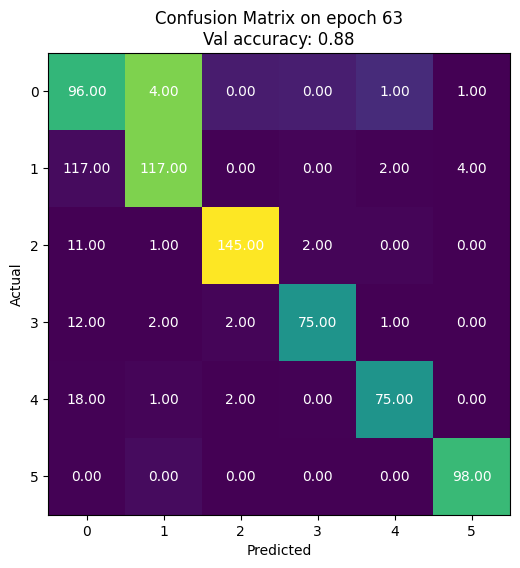

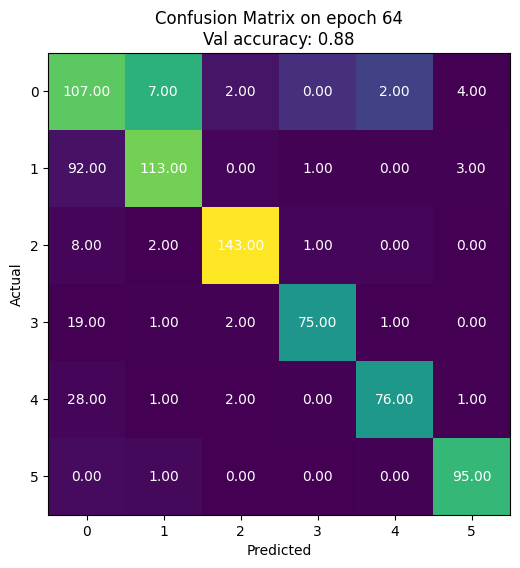

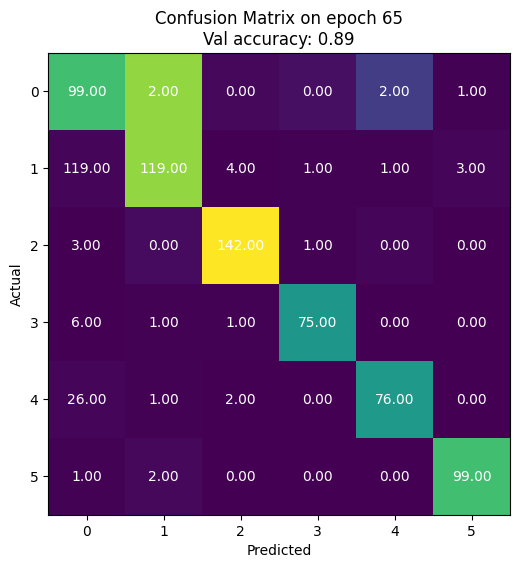

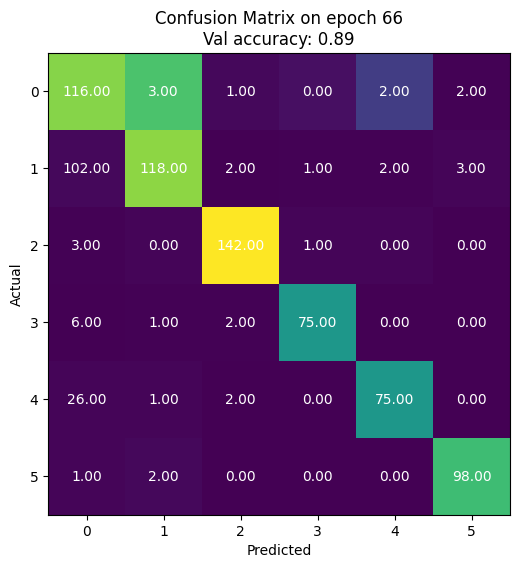

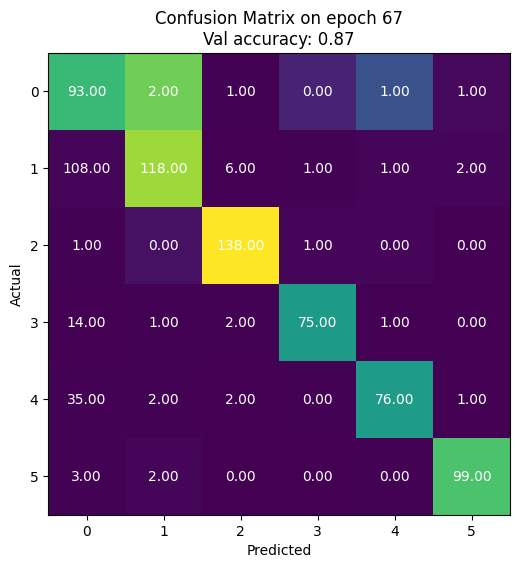

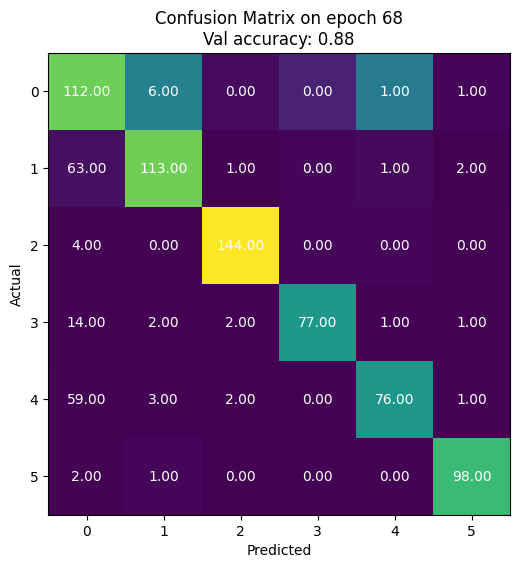

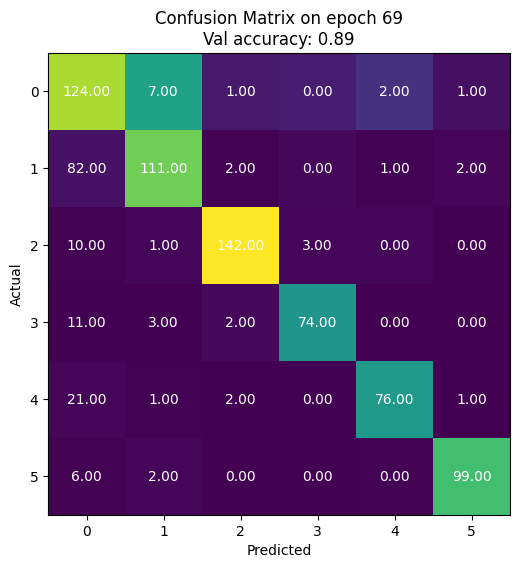

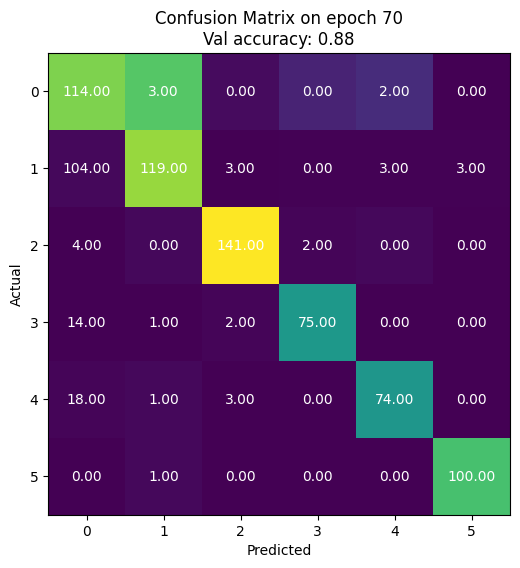

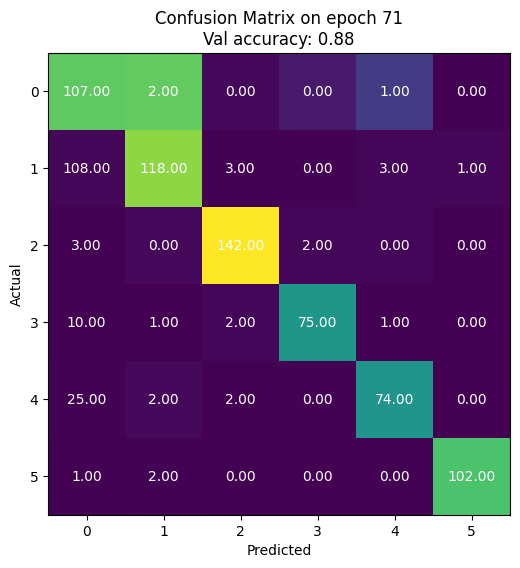

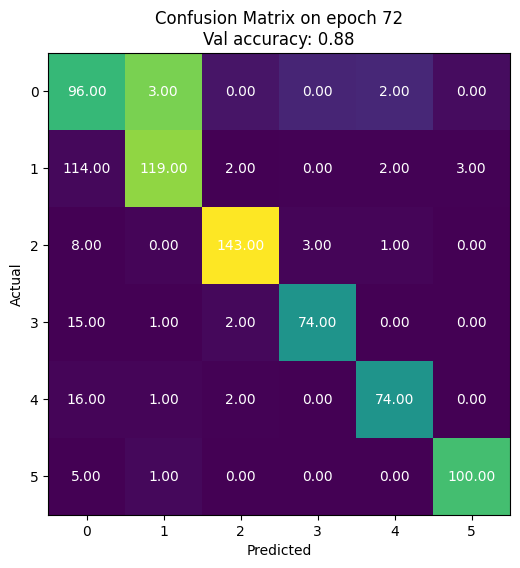

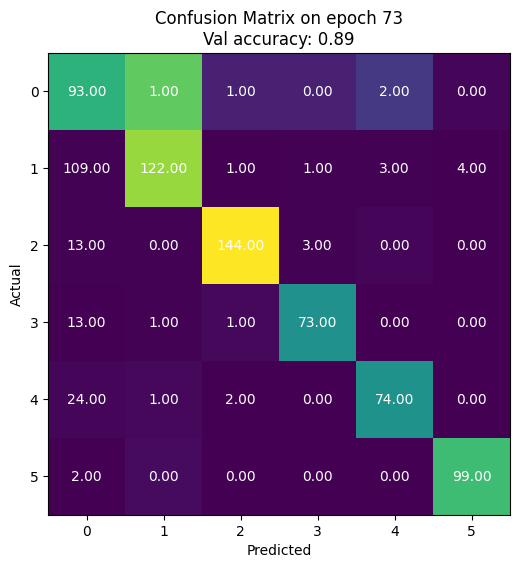

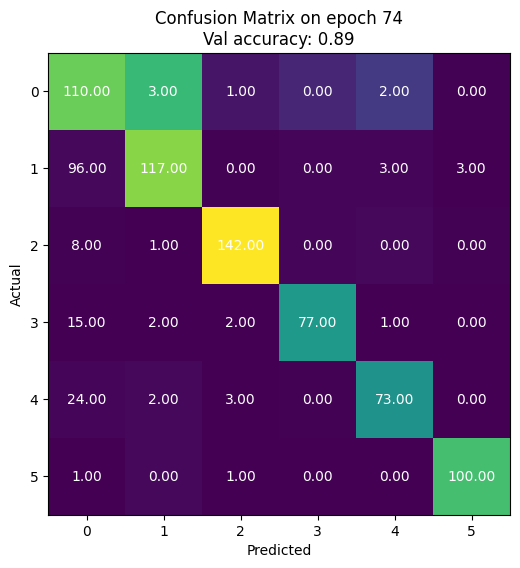

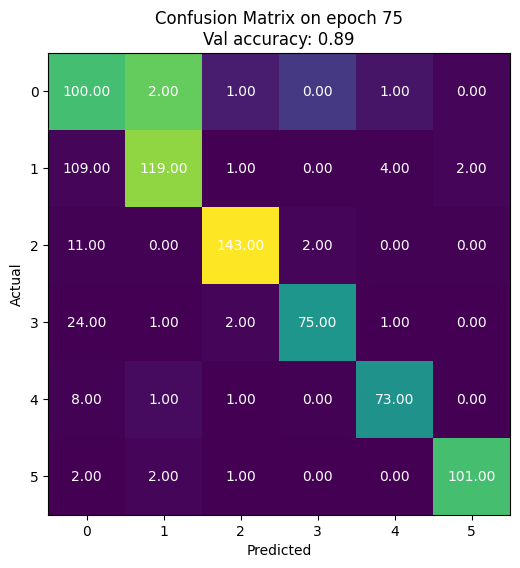

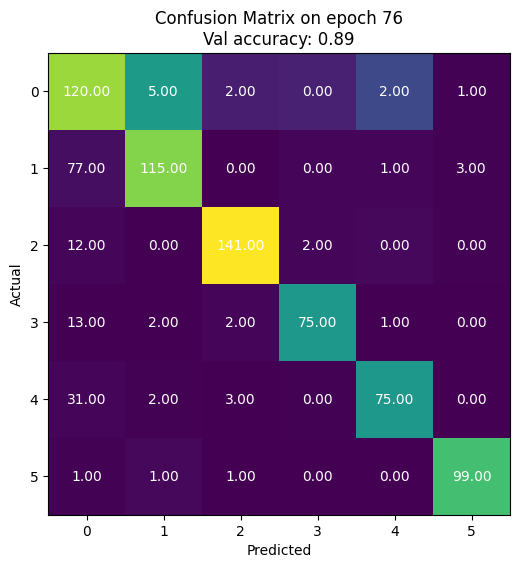

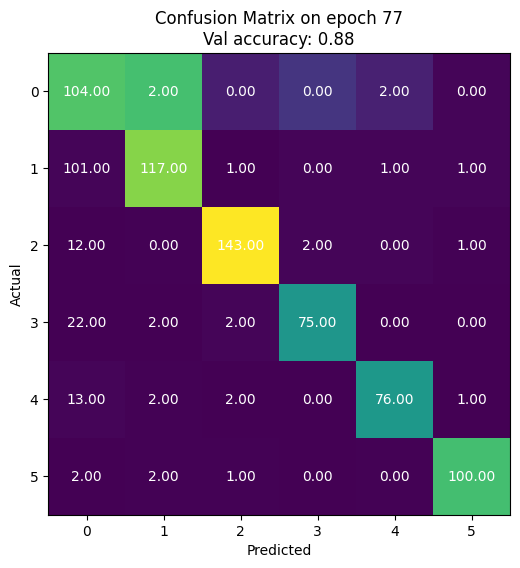

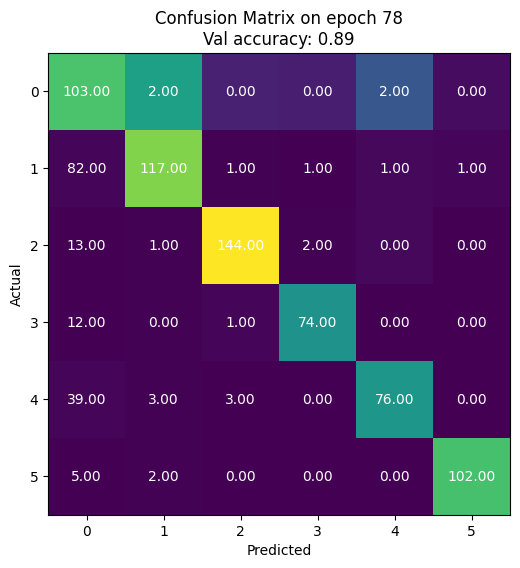

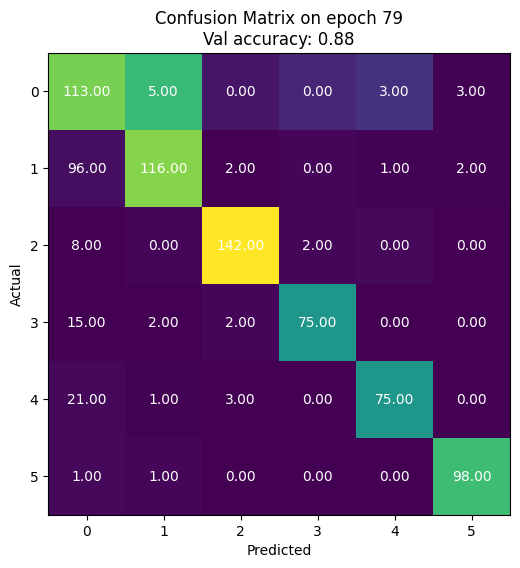

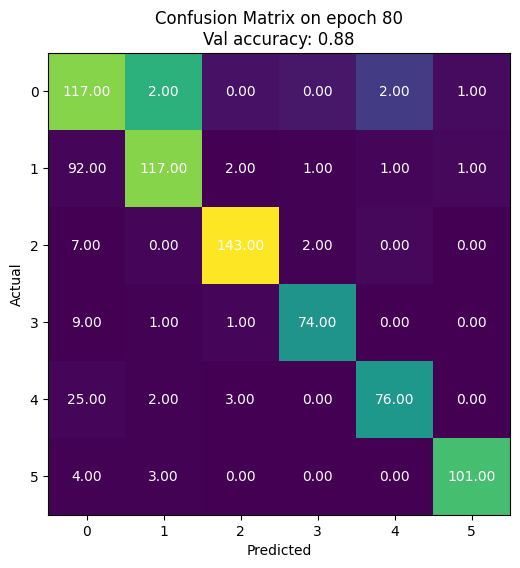

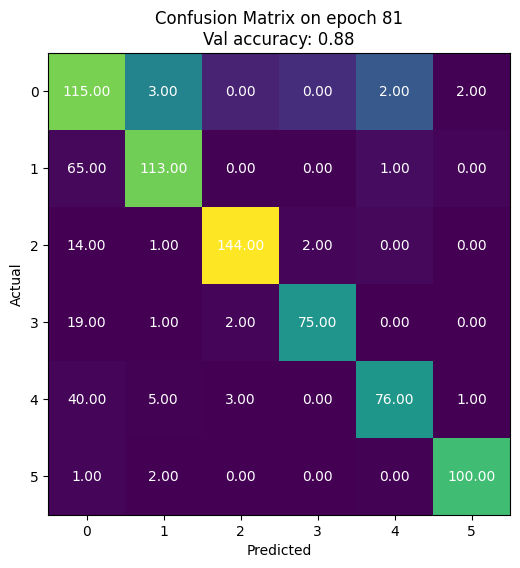

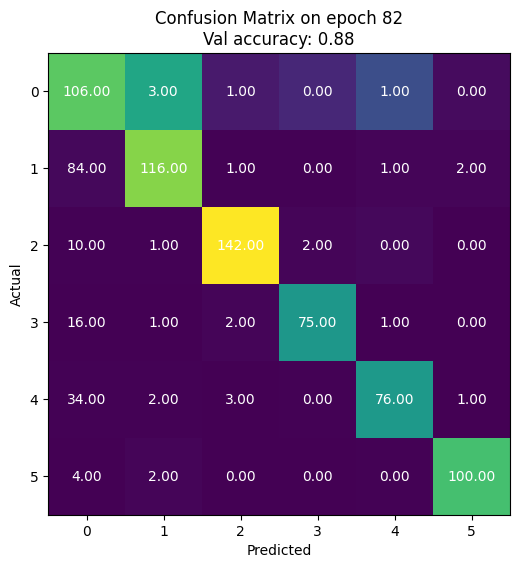

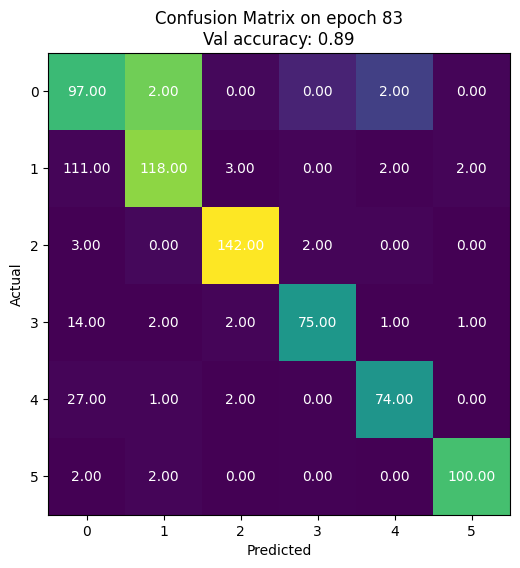

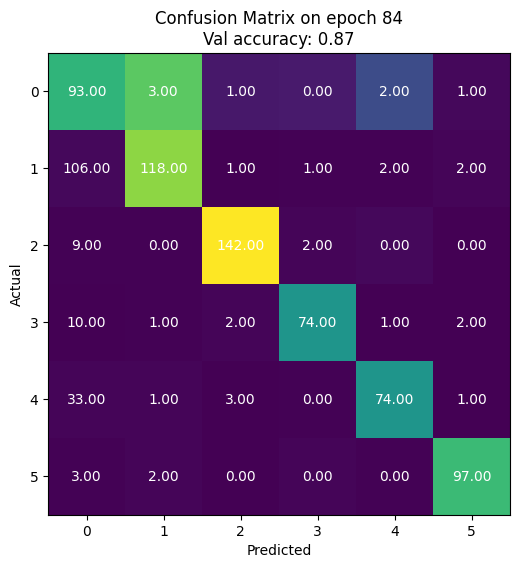

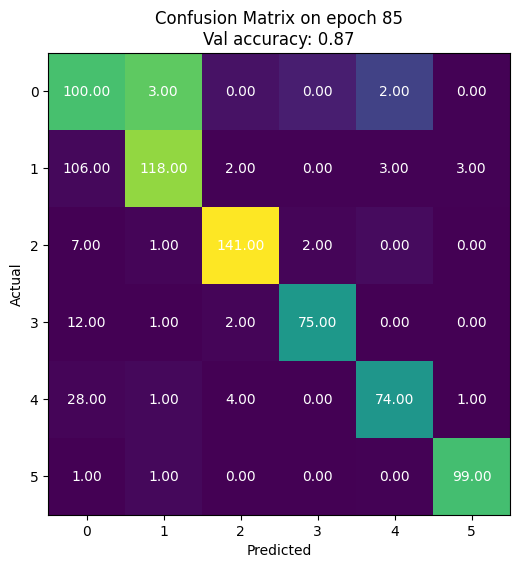

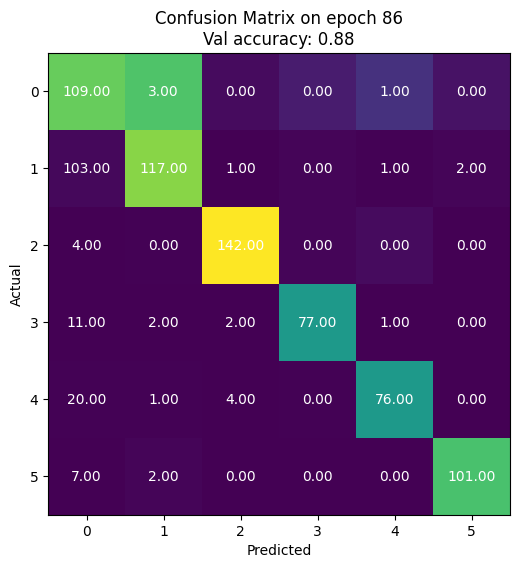

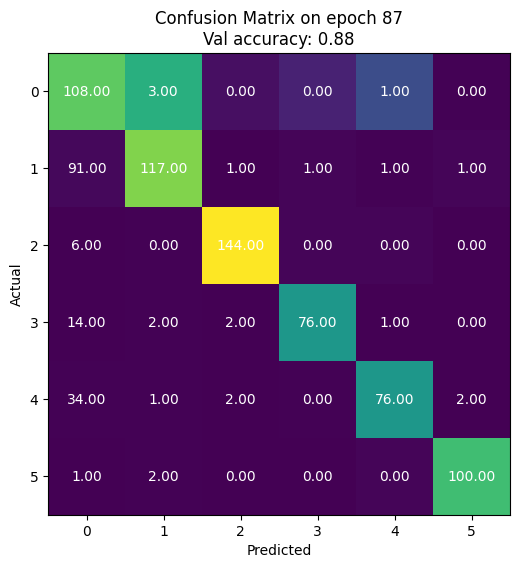

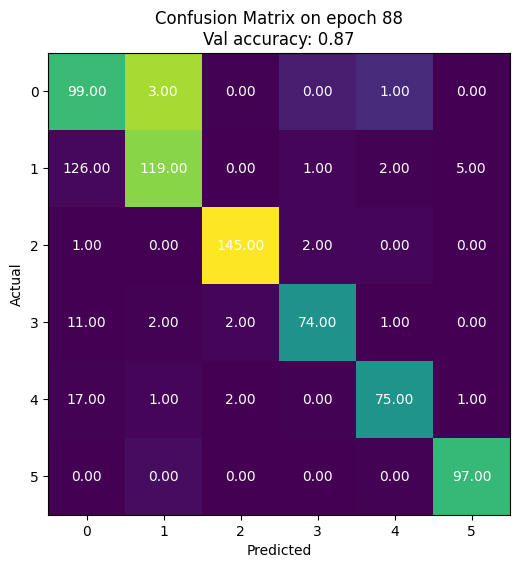

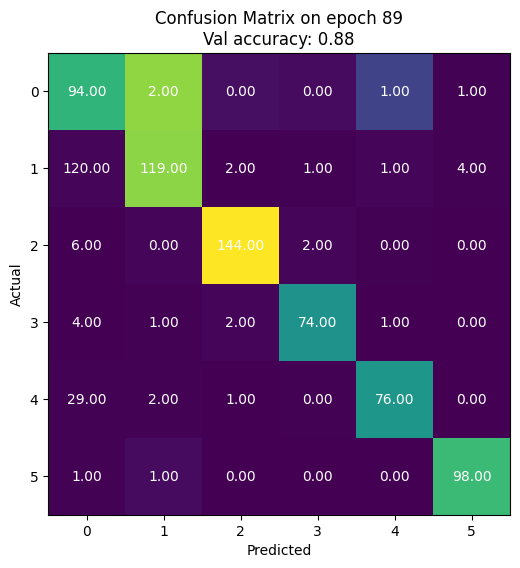

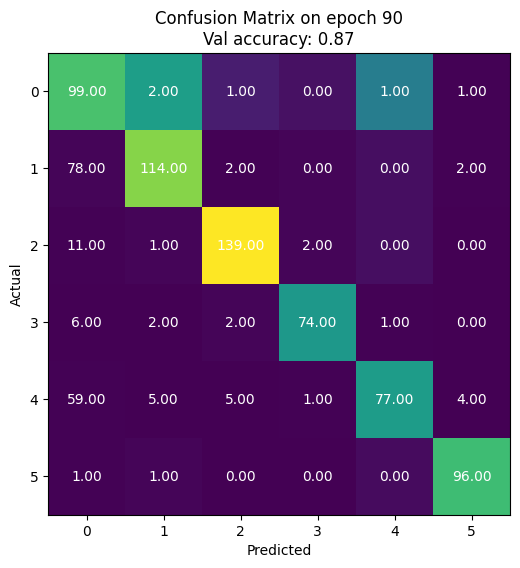

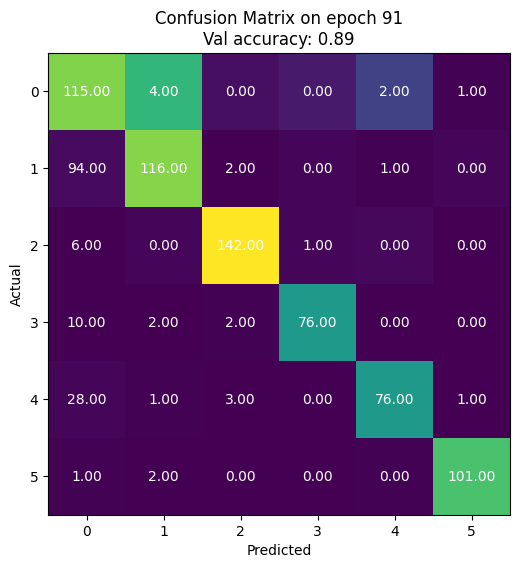

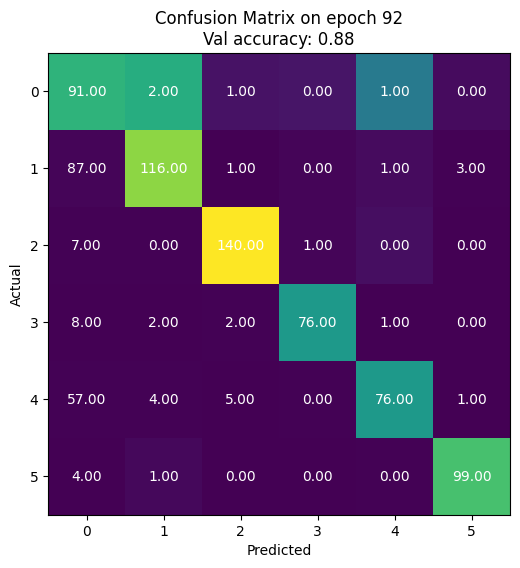

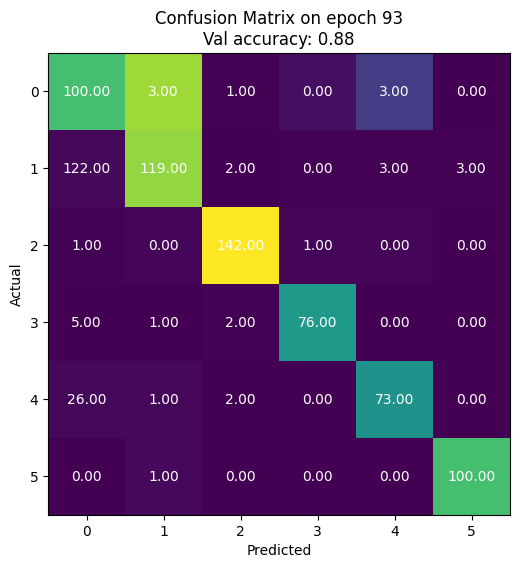

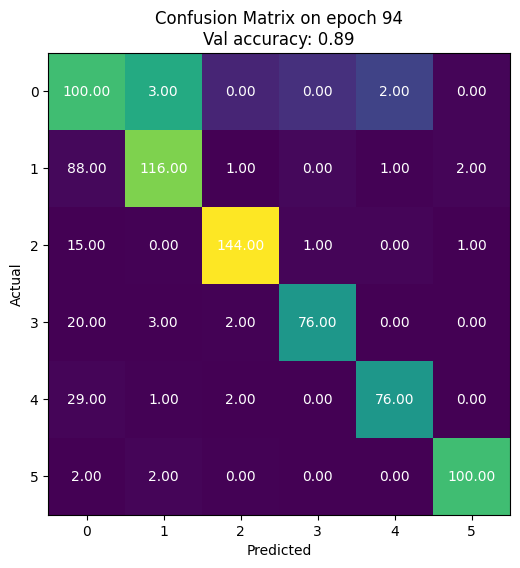

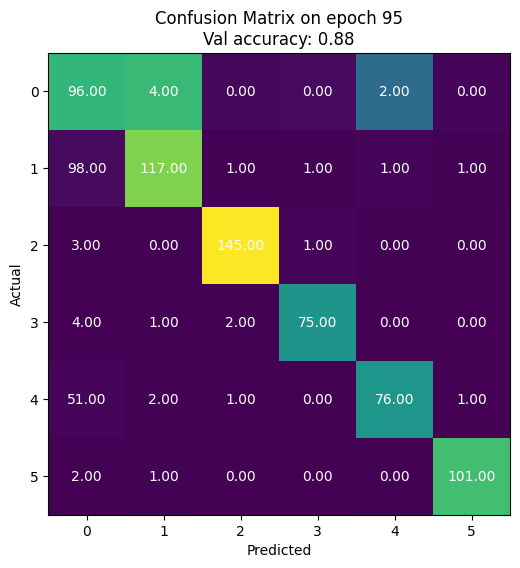

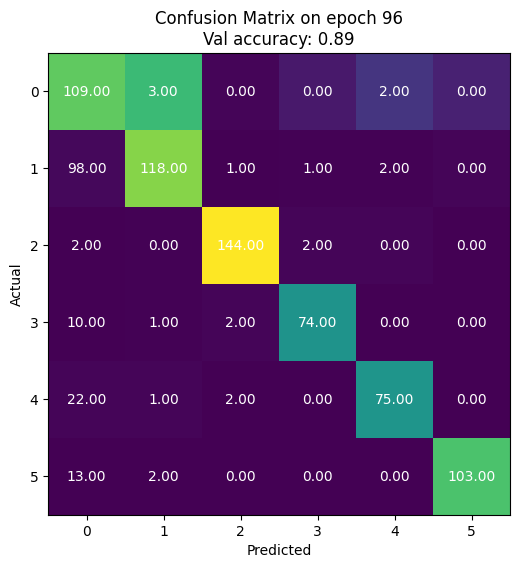

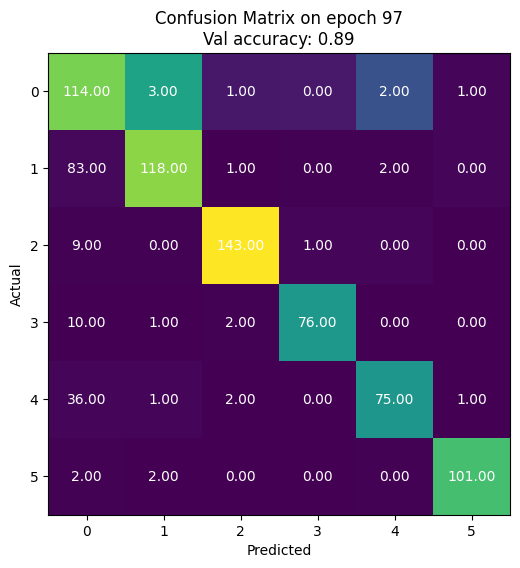

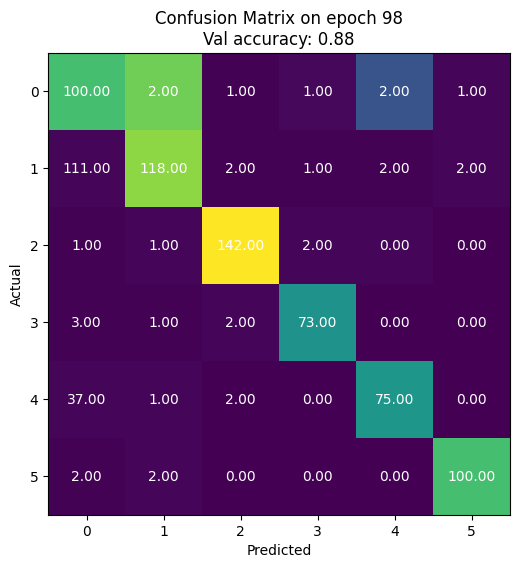

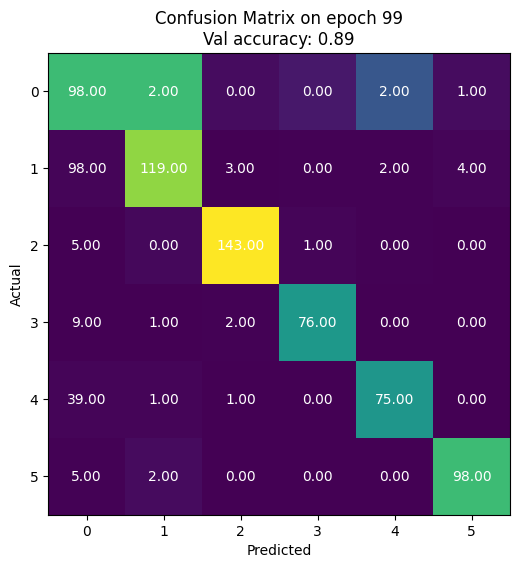

In [28]:
with tf.device('/gpu:0'):
# with tf.device('/gpu:0'):
    history = model.fit(
        train,
        validation_data=valid,
        epochs=100,
        callbacks=[bestCB, cmCB]
    )

In [29]:
model.save("./checkpoint/latest/")

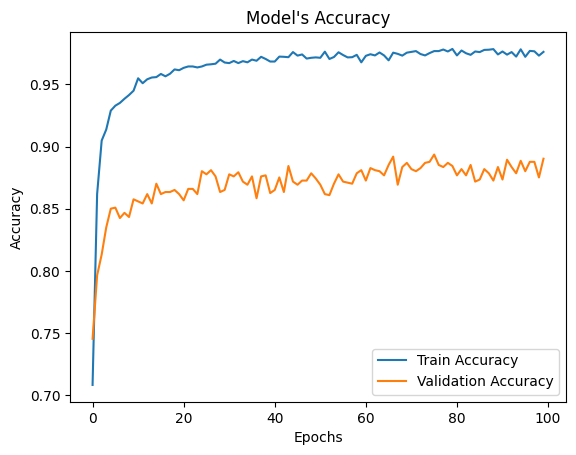

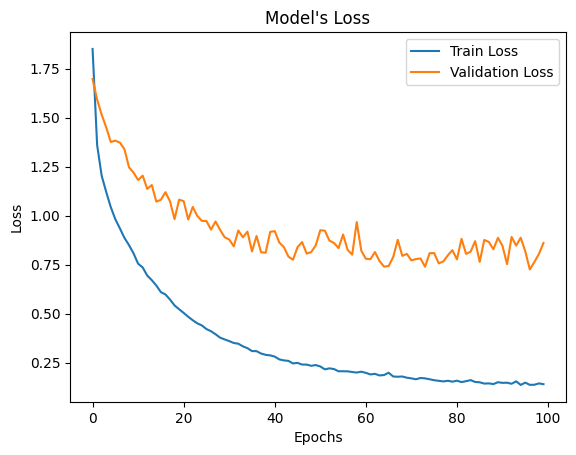

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model's Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model's Loss")
plt.legend()
plt.show()

#### **Evaluasi Model**


In [31]:
# Load iterasi terakhir
# model = tf.keras.models.load_model("./checkpoint/latest/")

# Load terbaik
model = tf.keras.models.load_model("./checkpoint/best/")

Test Dataset
Accuracy: 77.637%
Loss: 1.194


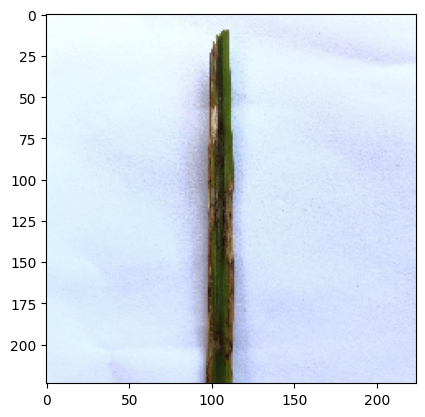

1/1 [==============================] - 1s 970ms/step
Label asli: BacterialBlight.
Prediksi 1 adalah: Blast (salah) dengan probabilitas 94.20%.
Prediksi 2 adalah: BacterialBlight (benar) dengan probabilitas 2.14%.
Prediksi 3 adalah: Tungro (salah) dengan probabilitas 1.50%.


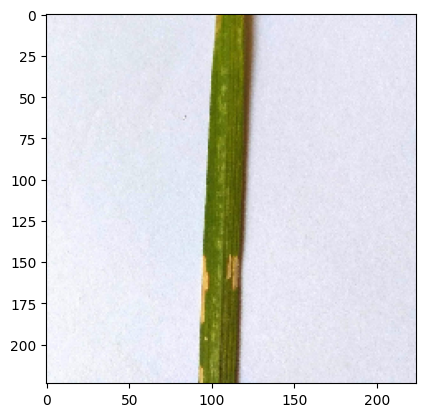

1/1 [==============================] - 0s 23ms/step
Label asli: Blast.
Prediksi 1 adalah: Blast (benar) dengan probabilitas 94.29%.
Prediksi 2 adalah: BacterialBlight (salah) dengan probabilitas 2.11%.
Prediksi 3 adalah: Tungro (salah) dengan probabilitas 1.46%.


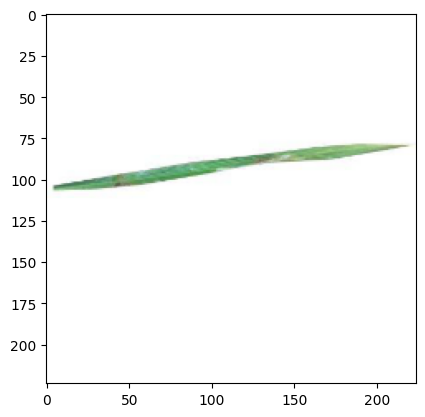

1/1 [==============================] - 0s 23ms/step
Label asli: BacterialBlight.
Prediksi 1 adalah: Blast (salah) dengan probabilitas 94.21%.
Prediksi 2 adalah: BacterialBlight (benar) dengan probabilitas 2.08%.
Prediksi 3 adalah: Tungro (salah) dengan probabilitas 1.50%.


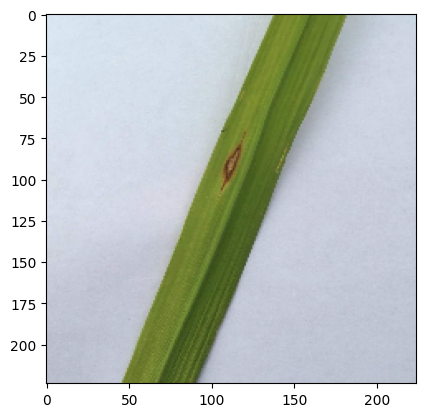

1/1 [==============================] - 0s 21ms/step
Label asli: Blast.
Prediksi 1 adalah: Blast (benar) dengan probabilitas 94.27%.
Prediksi 2 adalah: BacterialBlight (salah) dengan probabilitas 2.09%.
Prediksi 3 adalah: Tungro (salah) dengan probabilitas 1.49%.


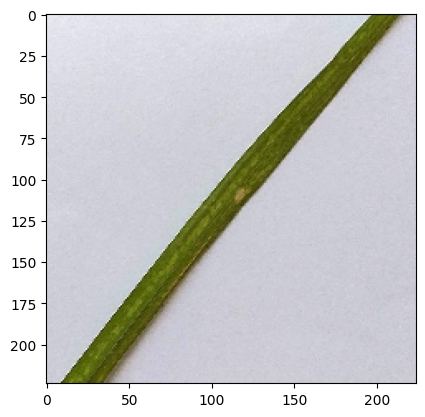

1/1 [==============================] - 0s 24ms/step
Label asli: Blast.
Prediksi 1 adalah: Blast (benar) dengan probabilitas 94.61%.
Prediksi 2 adalah: BacterialBlight (salah) dengan probabilitas 1.97%.
Prediksi 3 adalah: Brownspot (salah) dengan probabilitas 1.35%.


In [32]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_data, test_labels)).cache().batch(32).prefetch(AUTOTUNE)
eval_res = model.evaluate(test_dataset, verbose=0)
print(f"Test Dataset\nAccuracy: {eval_res[1]*100:.3f}%\nLoss: {eval_res[0]:.3f}")

topK = 3 # Ambil 3 kategori tertinggi untuk display ke user
for image, label in test_dataset.unbatch().shuffle(128).take(5):
    image = tf.cast(image, tf.uint8)
    plt.imshow(image)
    plt.show()

    image           = tf.cast(image, tf.float32) / 255
    image           = tf.expand_dims(image, axis=0)
    yhat            = model.predict(image)
    yhat_topk       = np.argpartition(-yhat, topK-1)[0][:3]
    true_label      = dict_disease[label.numpy()[0]]
    prob_res        = []
    disease_types   = []

    for disease in yhat_topk:
        disease_types.append(dict_disease[disease])
        prob_res.append(yhat[0][disease])
    
    print(f"Label asli: {true_label}.")
    for index_disease, disease in enumerate(disease_types):
        res = "benar" if true_label == disease else "salah"
        print(f"Prediksi {index_disease+1} adalah: {disease} ({res}) dengan probabilitas {prob_res[index_disease] * 100:.2f}%.")

In [33]:
!zip -r /content/checkpoint.zip /content/checkpoint/



  adding: content/checkpoint/ (stored 0%)
  adding: content/checkpoint/latest/ (stored 0%)
  adding: content/checkpoint/latest/keras_metadata.pb (deflated 89%)
  adding: content/checkpoint/latest/assets/ (stored 0%)
  adding: content/checkpoint/latest/fingerprint.pb (stored 0%)
  adding: content/checkpoint/latest/variables/ (stored 0%)
  adding: content/checkpoint/latest/variables/variables.index (deflated 76%)
  adding: content/checkpoint/latest/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/checkpoint/latest/saved_model.pb (deflated 91%)
  adding: content/checkpoint/best/ (stored 0%)
  adding: content/checkpoint/best/keras_metadata.pb (deflated 89%)
  adding: content/checkpoint/best/assets/ (stored 0%)
  adding: content/checkpoint/best/fingerprint.pb (stored 0%)
  adding: content/checkpoint/best/variables/ (stored 0%)
  adding: content/checkpoint/best/variables/variables.index (deflated 76%)
  adding: content/checkpoint/best/variables/variables.data-00000-of-